# Opportunity 2

## Imports

In [29]:
%matplotlib inline
import pandas as pd
import numpy as np
from pathlib import Path
import warnings
from fbprophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import math
import json
from prophet.serialize import model_to_json

warnings.simplefilter('ignore')

## Data setup

In [22]:
data_dir = Path('data')
stores_data = {}

for parquet_file in data_dir.glob('*.parquet*'):
    file_name = str(parquet_file).replace('data\sales-', '').replace('.parquet.gzip', '')
    stores_data[file_name] = {'sales_df': pd.read_parquet(parquet_file).drop(['SALES_DIST', 'SOLD_TO', 'SHIP_TO'], axis=1)}
    
stores_data

{'7003984': {'sales_df':            BILL_DATE  MATERIAL  PIEZAS
  8511      2019-03-03      2641       1
  8512      2019-03-03     12916       1
  8513      2019-03-03      2464       1
  9478      2019-03-03     11074       1
  9479      2019-03-03     20306       1
  ...              ...       ...     ...
  141730332 2020-09-17     31907       2
  141730333 2020-09-17     36526       2
  141730334 2020-09-17     36879       1
  141730335 2020-09-17     39950       5
  141730336 2020-09-17     44388       1
  
  [4333 rows x 3 columns]},
 '7007091': {'sales_df':            BILL_DATE  MATERIAL  PIEZAS
  17613     2019-03-03      9184       1
  17614     2019-03-03       495       1
  17615     2019-03-03       552       1
  18706     2019-03-03      2130       1
  41200     2019-03-03     12064       1
  ...              ...       ...     ...
  187137484 2021-03-30     32003       1
  187137485 2021-03-30     32334       1
  187516552 2021-03-31      7285       1
  187516553 2021-03-3

## Get first and last date for each store

In [23]:
for store, data in stores_data.items():
    df_sorted_by_dates = data['sales_df'].sort_values(by='BILL_DATE')
    data['oldest_date'] = df_sorted_by_dates.iloc[0]["BILL_DATE"]
    data['newest_date'] = df_sorted_by_dates.iloc[-1]["BILL_DATE"]
    data['number_of_days'] = (data['newest_date']-data['oldest_date']).days + 1

## Top 10 most sold products per store

In [24]:
for store, data in stores_data.items():
    product_sales = data['sales_df'].groupby(['MATERIAL'])['PIEZAS'].sum().sort_values(ascending=False)
    data['top_products'] = product_sales.head(10)

stores_data

{'7003984': {'sales_df':            BILL_DATE  MATERIAL  PIEZAS
  8511      2019-03-03      2641       1
  8512      2019-03-03     12916       1
  8513      2019-03-03      2464       1
  9478      2019-03-03     11074       1
  9479      2019-03-03     20306       1
  ...              ...       ...     ...
  141730332 2020-09-17     31907       2
  141730333 2020-09-17     36526       2
  141730334 2020-09-17     36879       1
  141730335 2020-09-17     39950       5
  141730336 2020-09-17     44388       1
  
  [4333 rows x 3 columns],
  'oldest_date': Timestamp('2019-03-03 00:00:00'),
  'newest_date': Timestamp('2020-09-17 00:00:00'),
  'number_of_days': 565,
  'top_products': MATERIAL
  1564     600
  4373      90
  3439      85
  12504     80
  3008      77
  6623      75
  27752     71
  4077      60
  7904      58
  4414      55
  Name: PIEZAS, dtype: int64},
 '7007091': {'sales_df':            BILL_DATE  MATERIAL  PIEZAS
  17613     2019-03-03      9184       1
  17614     201

## Get daily sales of top 10 products of each store

In [25]:
for store, data in stores_data.items():
    idx = pd.date_range(data['oldest_date'], data['newest_date'])
    data['top_products_sales'] = {}
    for product, sale in data['top_products'].iteritems():
        product_series = data['sales_df'][data['sales_df']["MATERIAL"] == product]
        product_series = product_series.groupby('BILL_DATE').PIEZAS.sum().to_frame(name = 'PIEZAS')

        product_series.index = pd.DatetimeIndex(product_series.index)
        product_series = product_series.reindex(idx, fill_value=0)
        product_series.index.name = "BILL_DATE"
        product_series = product_series.reset_index()
        data['top_products_sales'][product] = product_series

stores_data

{'7003984': {'sales_df':            BILL_DATE  MATERIAL  PIEZAS
  8511      2019-03-03      2641       1
  8512      2019-03-03     12916       1
  8513      2019-03-03      2464       1
  9478      2019-03-03     11074       1
  9479      2019-03-03     20306       1
  ...              ...       ...     ...
  141730332 2020-09-17     31907       2
  141730333 2020-09-17     36526       2
  141730334 2020-09-17     36879       1
  141730335 2020-09-17     39950       5
  141730336 2020-09-17     44388       1
  
  [4333 rows x 3 columns],
  'oldest_date': Timestamp('2019-03-03 00:00:00'),
  'newest_date': Timestamp('2020-09-17 00:00:00'),
  'number_of_days': 565,
  'top_products': MATERIAL
  1564     600
  4373      90
  3439      85
  12504     80
  3008      77
  6623      75
  27752     71
  4077      60
  7904      58
  4414      55
  Name: PIEZAS, dtype: int64,
  'top_products_sales': {1564:      BILL_DATE  PIEZAS
   0   2019-03-03       0
   1   2019-03-04       0
   2   2019-03-

## Forecast the next 7 days for each of the top 10 products at each store

In [40]:
for store in stores_data: 
    print(f'Store: {store}')
    stores_data[store]['models'] = {}
    stores_data[store]['predictions'] = {}
    stores_data[store]['fbp_objects'] = {}
    for product in stores_data[store]['top_products_sales']:
        print(f'Product: {product}')
        daily_sales = stores_data[store]['top_products_sales'][product]
        daily_sales.columns = ['ds', 'y']
        m = Prophet(interval_width=0.95, daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True) 
        m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
        stores_data[store]['models'][product] = m.fit(daily_sales)
        future = m.make_future_dataframe(periods=7, freq='D')
        forecast = m.predict(future)
        print(forecast[['ds', 'yhat']])
        #forecast = forecast.tail(7)
        stores_data[store]['predictions'][product] = forecast
        stores_data[store]['fbp_objects'][product] = m

Store: 7003984
Product: 1564
            ds      yhat
0   2019-03-03 -1.752642
1   2019-03-04  1.368754
2   2019-03-05 -3.019602
3   2019-03-06 -1.739344
4   2019-03-07 -0.407769
..         ...       ...
567 2020-09-20 -3.856374
568 2020-09-21  1.760386
569 2020-09-22 -0.461713
570 2020-09-23  1.208711
571 2020-09-24  0.728438

[572 rows x 2 columns]
Product: 4373
            ds      yhat
0   2019-03-03  0.348672
1   2019-03-04  0.907767
2   2019-03-05  1.370866
3   2019-03-06  0.973591
4   2019-03-07  0.961576
..         ...       ...
567 2020-09-20 -0.292501
568 2020-09-21 -0.216874
569 2020-09-22 -0.031943
570 2020-09-23 -0.361529
571 2020-09-24 -0.038742

[572 rows x 2 columns]
Product: 3439
            ds      yhat
0   2019-03-03  0.267190
1   2019-03-04  0.326893
2   2019-03-05  0.220622
3   2019-03-06 -0.019305
4   2019-03-07  0.202522
..         ...       ...
567 2020-09-20 -0.400015
568 2020-09-21 -0.232874
569 2020-09-22 -0.296041
570 2020-09-23 -0.537866
571 2020-09-24 -0.30

            ds      yhat
0   2019-03-04  0.648539
1   2019-03-05 -0.108530
2   2019-03-06 -0.292271
3   2019-03-07 -0.414695
4   2019-03-08 -0.402722
..         ...       ...
759 2021-04-01  0.254434
760 2021-04-02  0.239096
761 2021-04-03  0.314117
762 2021-04-04  0.373003
763 2021-04-05  0.957935

[764 rows x 2 columns]
Product: 9664
            ds      yhat
0   2019-03-04  0.544926
1   2019-03-05  0.155869
2   2019-03-06  0.137432
3   2019-03-07  0.264020
4   2019-03-08 -0.000328
..         ...       ...
759 2021-04-01 -0.006840
760 2021-04-02 -0.221924
761 2021-04-03 -0.197299
762 2021-04-04 -0.135149
763 2021-04-05  0.353606

[764 rows x 2 columns]
Product: 3953
            ds      yhat
0   2019-03-04  0.241203
1   2019-03-05 -0.079961
2   2019-03-06 -0.176921
3   2019-03-07 -0.005718
4   2019-03-08 -0.174953
..         ...       ...
759 2021-04-01  0.316115
760 2021-04-02  0.146790
761 2021-04-03  0.144548
762 2021-04-04  0.170978
763 2021-04-05  0.392219

[764 rows x 2 columns]


            ds      yhat
0   2019-03-06  0.960913
1   2019-03-07  0.675711
2   2019-03-08  0.801006
3   2019-03-09  0.697153
4   2019-03-10  1.158338
..         ...       ...
759 2021-04-03  0.200821
760 2021-04-04  0.498827
761 2021-04-05  0.801290
762 2021-04-06  0.353360
763 2021-04-07  0.302198

[764 rows x 2 columns]
Product: 3444
            ds      yhat
0   2019-03-06  0.422877
1   2019-03-07 -0.184857
2   2019-03-08  0.171335
3   2019-03-09 -0.106256
4   2019-03-10  0.621455
..         ...       ...
759 2021-04-03  0.469374
760 2021-04-04  1.013481
761 2021-04-05  0.145023
762 2021-04-06  0.189001
763 2021-04-07  0.433131

[764 rows x 2 columns]
Product: 4103
            ds      yhat
0   2019-03-06 -0.006482
1   2019-03-07  0.022051
2   2019-03-08  0.236195
3   2019-03-09 -0.147198
4   2019-03-10  0.177903
..         ...       ...
759 2021-04-03  0.198539
760 2021-04-04  0.542108
761 2021-04-05  0.425229
762 2021-04-06  0.464761
763 2021-04-07  0.363087

[764 rows x 2 columns]


## Round forecasted values and turn negative ones into 0

In [33]:
for store in stores_data:
    print(f'Store: {store}')
    for product in stores_data[store]['top_products_sales']:
        print(f'Product: {product}')
        stores_data[store]['predictions'][product]['yhat'] = round(stores_data[store]['predictions'][product]['yhat'])
        stores_data[store]['predictions'][product][stores_data[store]['predictions'][product]['yhat'] <= 0]['yhat'] = 0
        print(stores_data[store]['predictions'][product])

Store: 7003984
Product: 1564
            ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0   2019-03-03  0.425932  -20.733731   16.930422     0.425932     0.425932   
1   2019-03-04  0.421771  -17.597225   20.303079     0.421771     0.421771   
2   2019-03-05  0.417610  -23.250955   15.719102     0.417610     0.417610   
3   2019-03-06  0.413449  -20.844471   17.345148     0.413449     0.413449   
4   2019-03-07  0.409288  -20.002355   20.104413     0.409288     0.409288   
..         ...       ...         ...         ...          ...          ...   
567 2020-09-20 -1.920652  -24.616519   14.240659    -1.920654    -1.920649   
568 2020-09-21 -1.924760  -17.967790   20.214263    -1.924764    -1.924755   
569 2020-09-22 -1.928868  -19.718267   19.218382    -1.928874    -1.928859   
570 2020-09-23 -1.932976  -17.880582   20.545687    -1.932984    -1.932962   
571 2020-09-24 -1.937084  -18.565379   21.240065    -1.937094    -1.937066   

     additive_terms  additive_term

            ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0   2019-03-03  0.058810   -0.552318    1.335320     0.058810     0.058810   
1   2019-03-04  0.058394   -0.399120    1.305796     0.058394     0.058394   
2   2019-03-05  0.057978   -0.618113    1.214377     0.057978     0.057978   
3   2019-03-06  0.057561   -0.679124    1.062509     0.057561     0.057561   
4   2019-03-07  0.057145   -0.762826    0.968287     0.057145     0.057145   
..         ...       ...         ...         ...          ...          ...   
762 2021-04-03 -0.263228   -1.171924    0.574613    -0.263229    -0.263228   
763 2021-04-04 -0.263655   -0.780780    0.983318    -0.263656    -0.263654   
764 2021-04-05 -0.264081   -0.835178    0.979517    -0.264082    -0.264081   
765 2021-04-06 -0.264508   -1.000242    0.715764    -0.264510    -0.264507   
766 2021-04-07 -0.264934   -1.133009    0.649617    -0.264937    -0.264933   

     additive_terms  additive_terms_lower  additive_terms_upper

Product: 15590
            ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0   2019-03-06  0.087094   -2.123784    3.773564     0.087094     0.087094   
1   2019-03-07  0.086648   -2.862321    2.716237     0.086648     0.086648   
2   2019-03-08  0.086202   -2.827374    2.894705     0.086202     0.086202   
3   2019-03-09  0.085757   -2.895830    2.857934     0.085757     0.085757   
4   2019-03-10  0.085311   -2.191551    3.490491     0.085311     0.085311   
..         ...       ...         ...         ...          ...          ...   
752 2021-03-27 -0.253672   -2.636064    3.193653    -0.253672    -0.253672   
753 2021-03-28 -0.254125   -1.832785    4.126200    -0.254126    -0.254125   
754 2021-03-29 -0.254579   -2.721917    3.106902    -0.254579    -0.254578   
755 2021-03-30 -0.255032   -2.615457    3.392472    -0.255033    -0.255031   
756 2021-03-31 -0.255485   -1.094686    4.705340    -0.255487    -0.255484   

     additive_terms  additive_terms_lower  addit

            ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0   2019-03-04  0.014078   -2.085993    1.556042     0.014078     0.014078   
1   2019-03-05  0.014086   -2.223429    1.627284     0.014086     0.014086   
2   2019-03-06  0.014094   -1.854505    1.888701     0.014094     0.014094   
3   2019-03-07  0.014102   -1.797908    1.825463     0.014102     0.014102   
4   2019-03-08  0.014110   -1.734676    2.095214     0.014110     0.014110   
..         ...       ...         ...         ...          ...          ...   
753 2021-03-26  0.028662   -1.648891    2.105252     0.028662     0.028663   
754 2021-03-27  0.028685   -2.033764    1.821108     0.028684     0.028686   
755 2021-03-28  0.028707   -1.986157    1.779655     0.028706     0.028709   
756 2021-03-29  0.028730   -2.002614    1.717950     0.028728     0.028732   
757 2021-03-30  0.028752   -1.933620    1.921760     0.028750     0.028755   

     additive_terms  additive_terms_lower  additive_terms_upper

            ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0   2019-11-03  0.052658   -4.776042    3.567790     0.052658     0.052658   
1   2019-11-04  0.053327   -3.935035    4.923367     0.053327     0.053327   
2   2019-11-05  0.053996   -4.287039    4.184676     0.053996     0.053996   
3   2019-11-06  0.054666   -5.219186    3.472367     0.054666     0.054666   
4   2019-11-07  0.055335   -4.746338    3.704079     0.055335     0.055335   
..         ...       ...         ...         ...          ...          ...   
517 2021-04-03  0.398663   -4.214617    3.978270     0.398663     0.398663   
518 2021-04-04  0.399333   -4.241423    4.767811     0.399333     0.399333   
519 2021-04-05  0.400002   -2.867027    5.323327     0.400002     0.400002   
520 2021-04-06  0.400671   -3.321557    5.089161     0.400671     0.400671   
521 2021-04-07  0.401340   -3.754727    4.479949     0.401340     0.401340   

     additive_terms  additive_terms_lower  additive_terms_upper

## Plot models with all data

Store: 7003984
Product: 1564
Product: 4373
Product: 3439
Product: 12504
Product: 3008
Product: 6623
Product: 27752
Product: 4077
Product: 7904
Product: 4414
Store: 7007091
Product: 6969
Product: 6207
Product: 6962
Product: 6963
Product: 188
Product: 3591
Product: 3590
Product: 3556
Product: 6213
Product: 22572
Store: 7017139
Product: 4101
Product: 13165
Product: 4124
Product: 19197
Product: 4373
Product: 4102
Product: 9664
Product: 3953
Product: 3954
Product: 4108
Store: 7022906
Product: 15590
Product: 21256
Product: 8650
Product: 18761
Product: 28727
Product: 32002
Product: 28725
Product: 8657
Product: 28726
Product: 8649
Store: 7023126
Product: 2541
Product: 29725
Product: 29258
Product: 38054
Product: 20791
Product: 3439
Product: 2342
Product: 12081
Product: 29257
Product: 16869
Store: 7029898
Product: 4373
Product: 3444
Product: 4103
Product: 1883
Product: 43629
Product: 6248
Product: 44066
Product: 18891
Product: 43598
Product: 15932
Store: 7036861
Product: 42830
Product: 42915
Pr

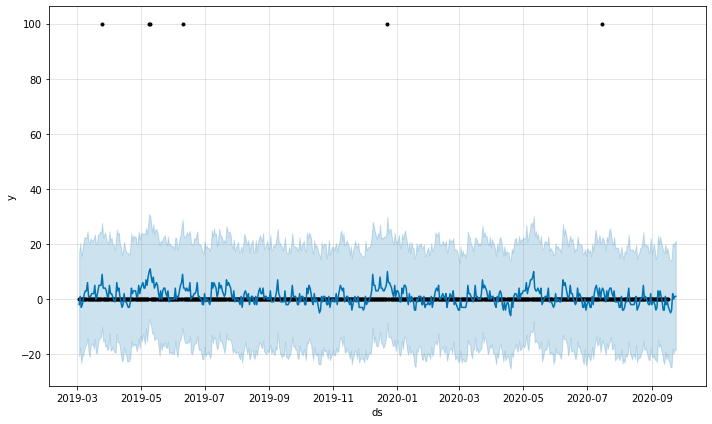

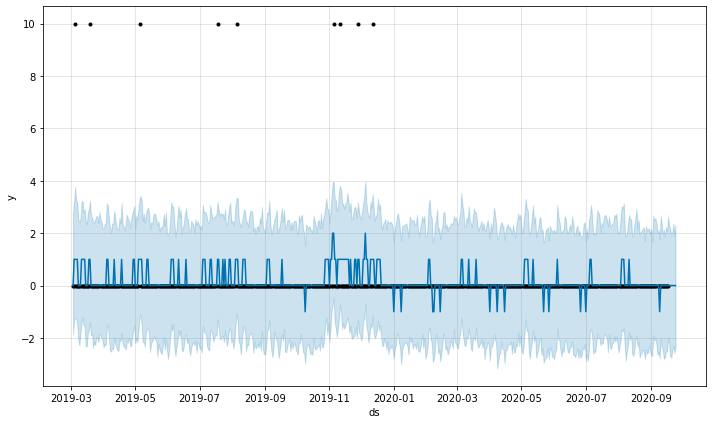

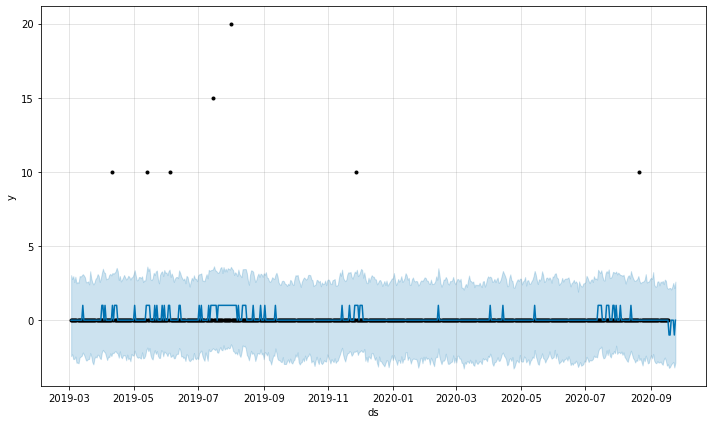

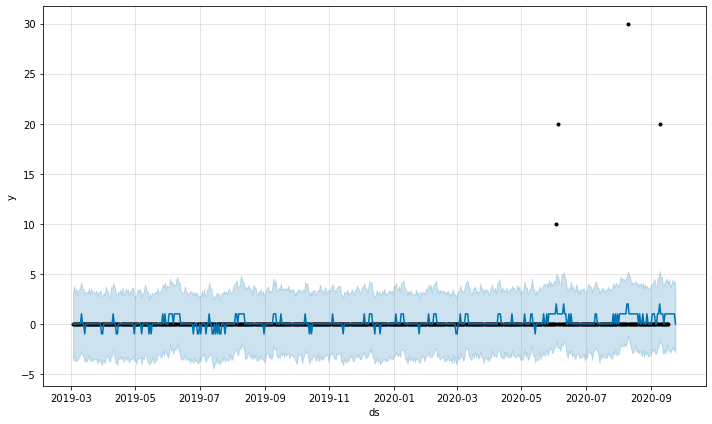

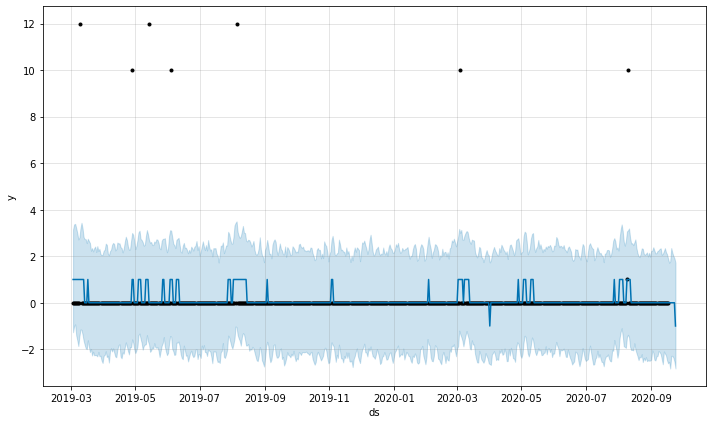

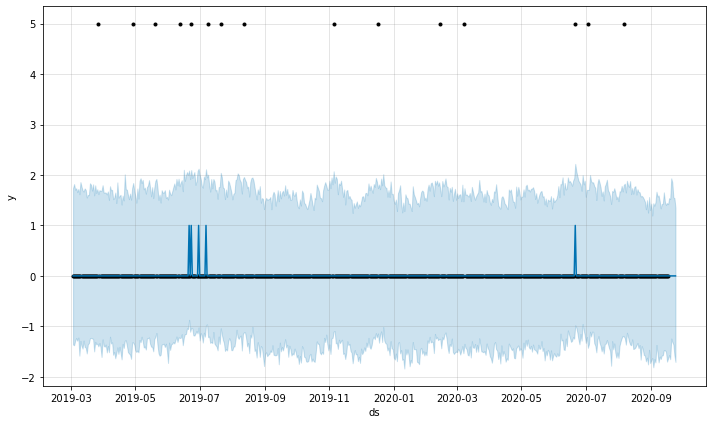

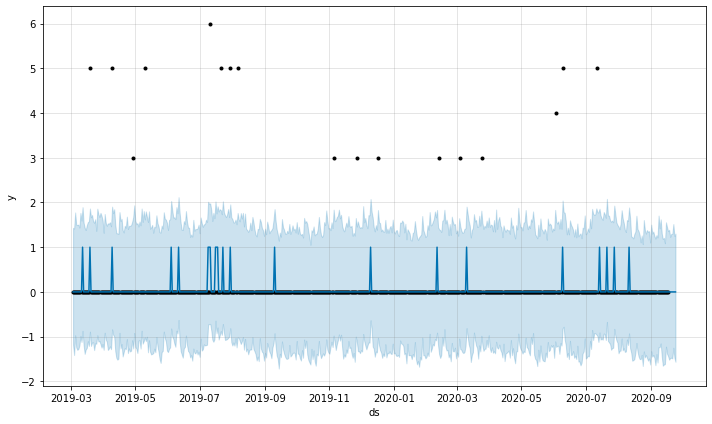

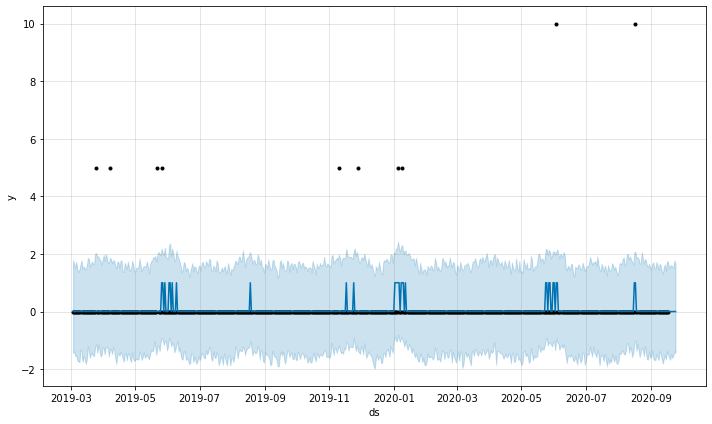

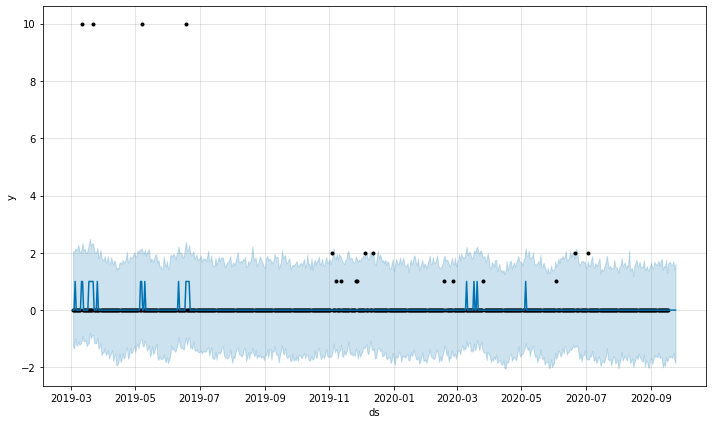

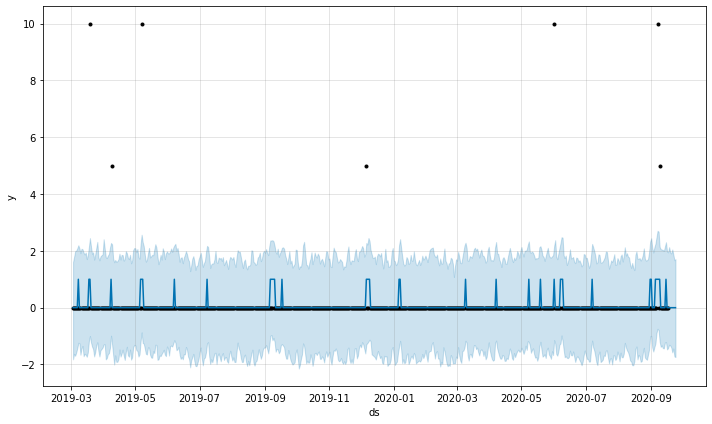

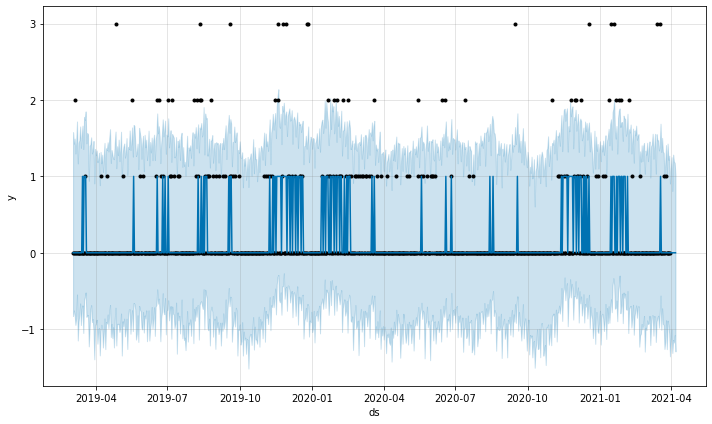

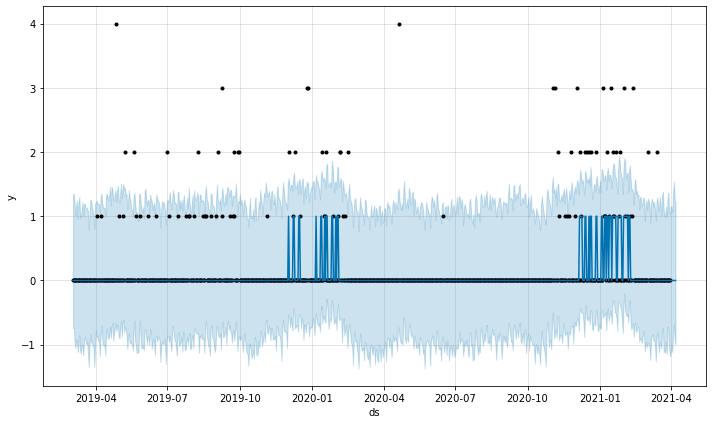

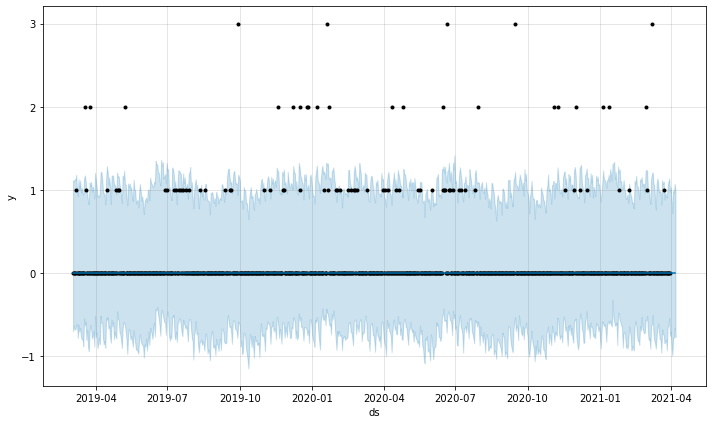

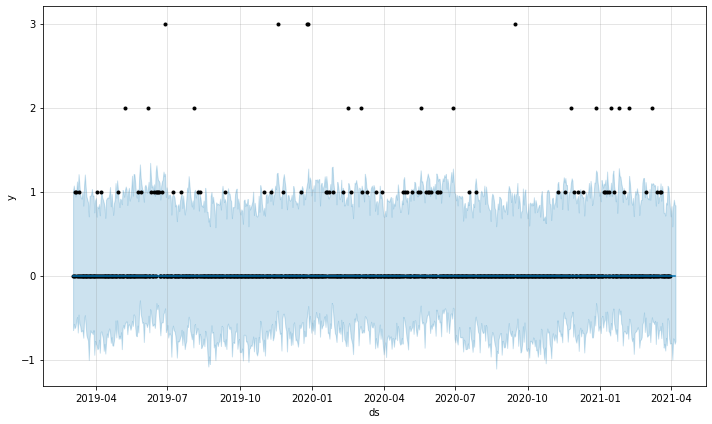

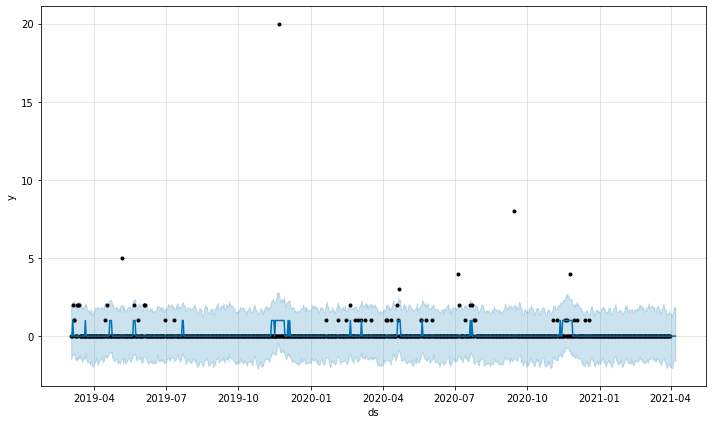

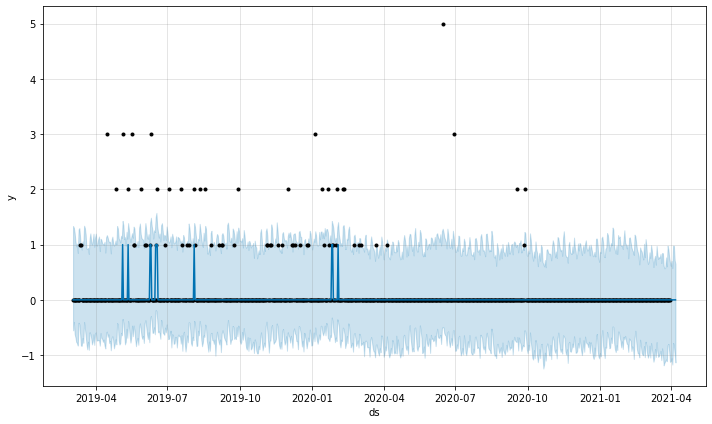

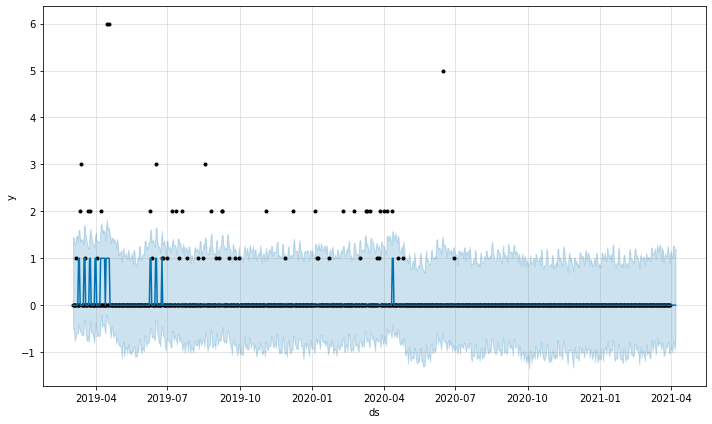

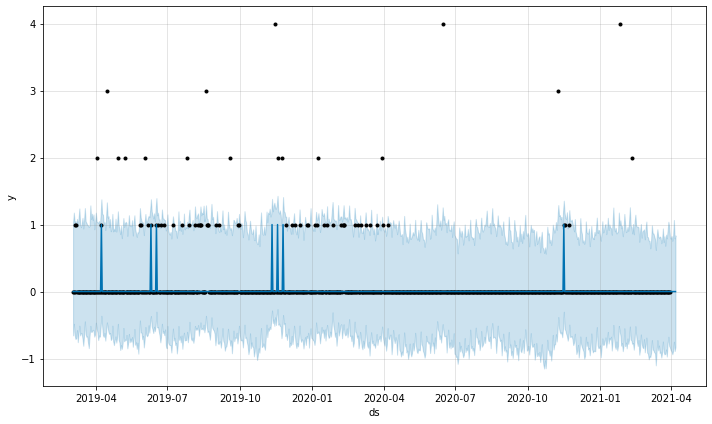

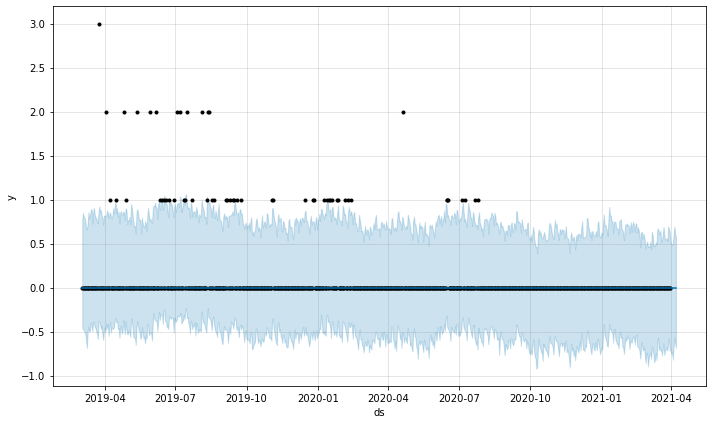

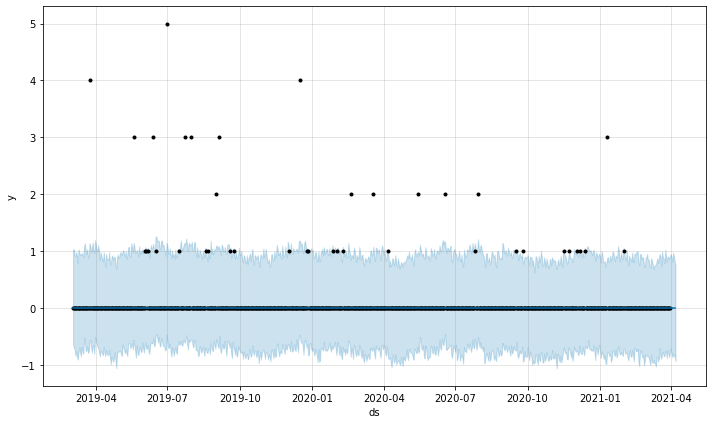

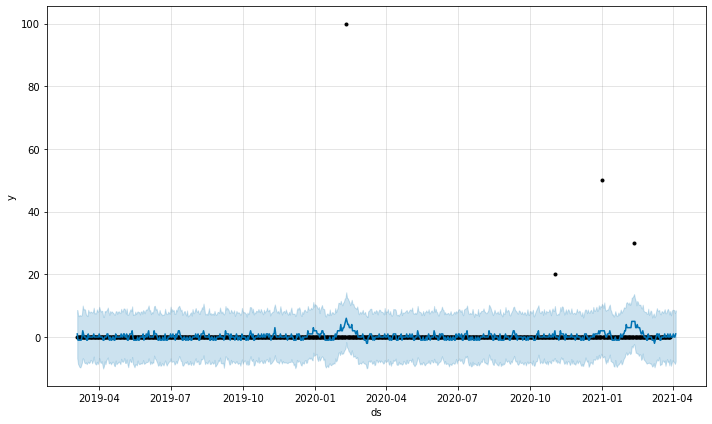

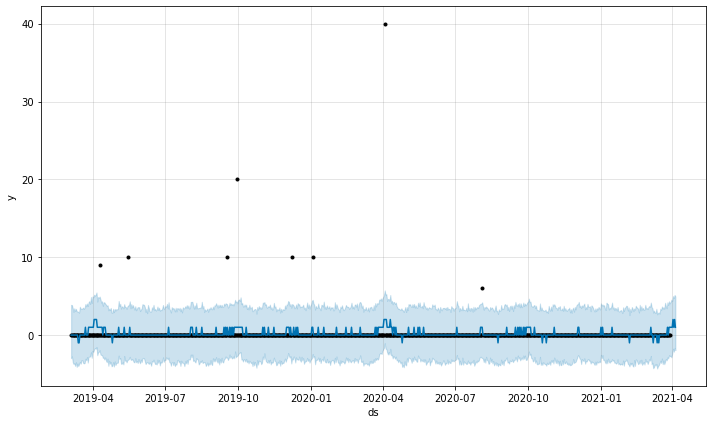

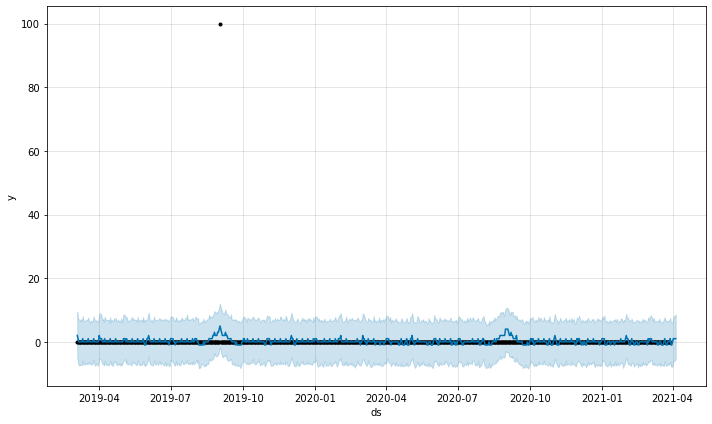

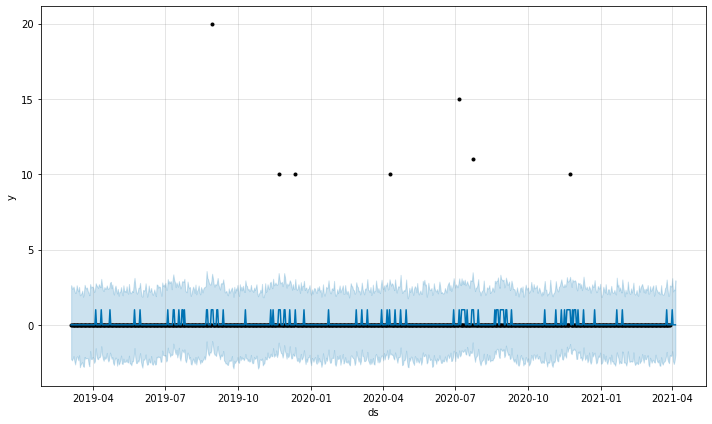

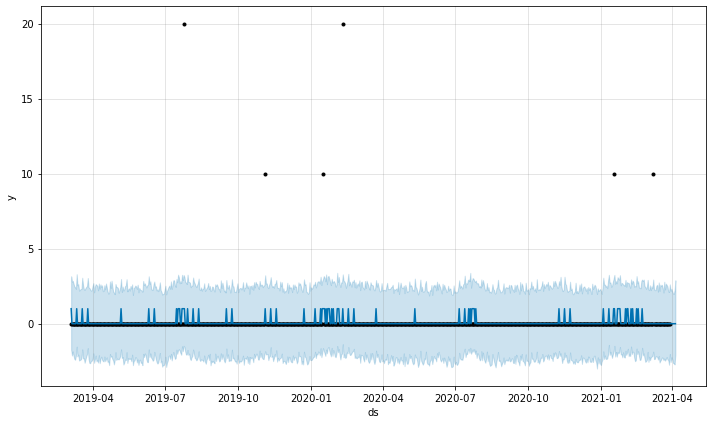

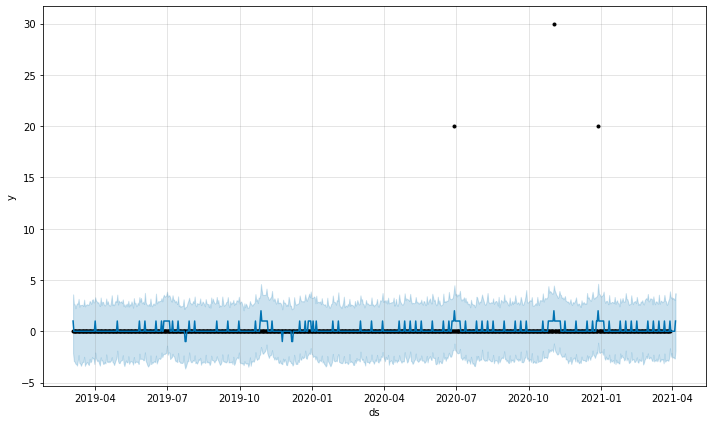

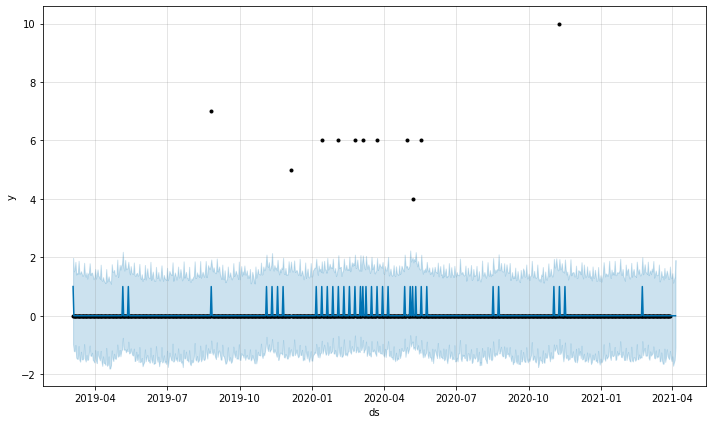

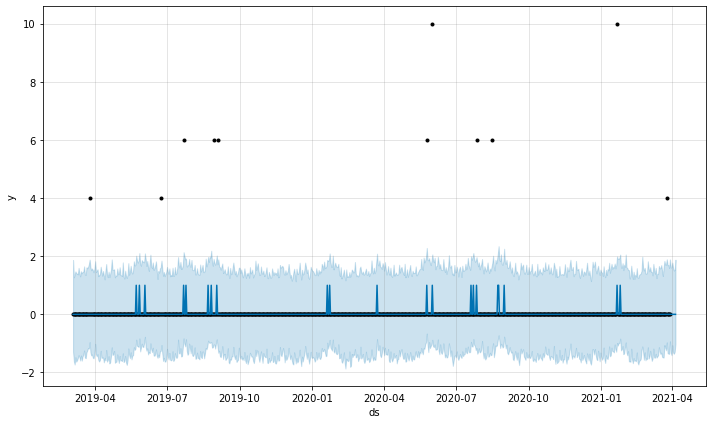

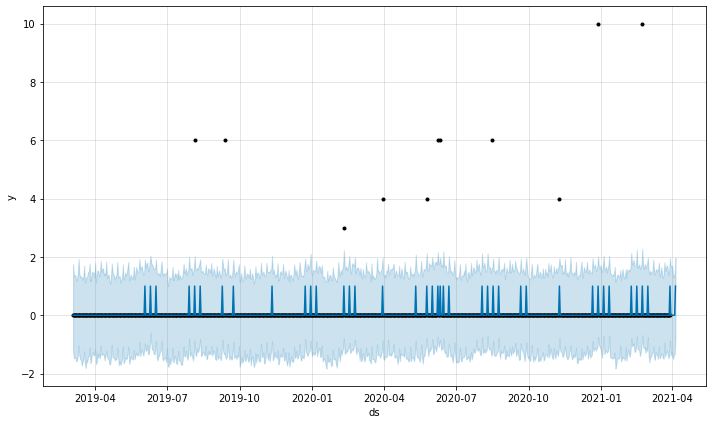

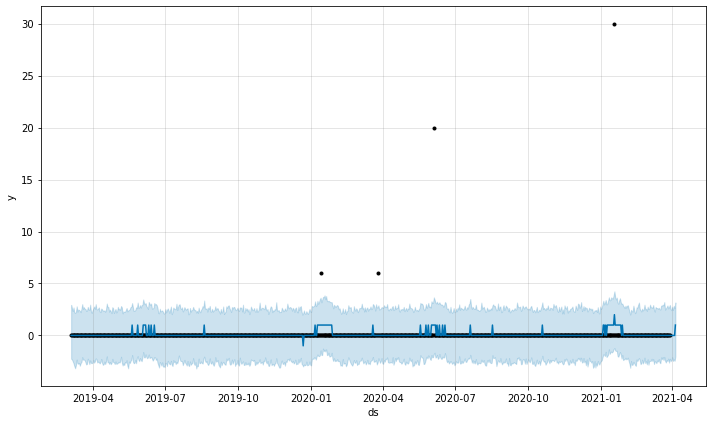

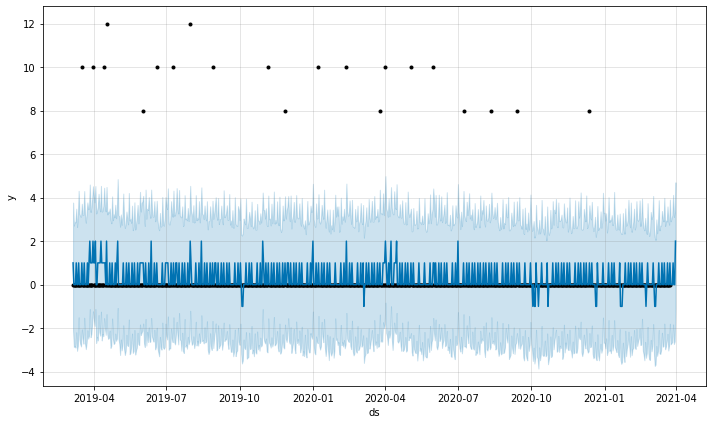

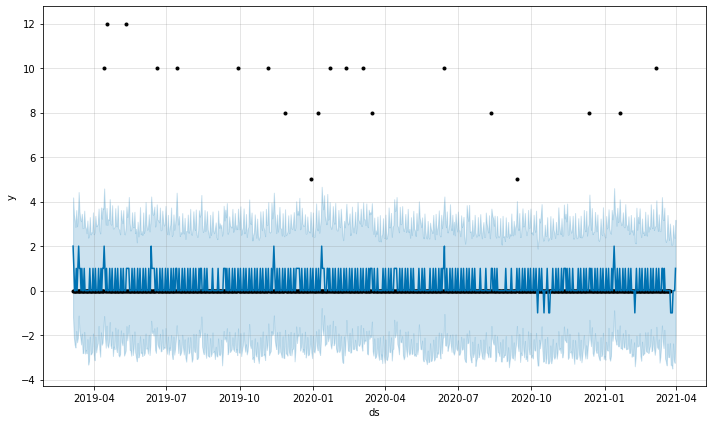

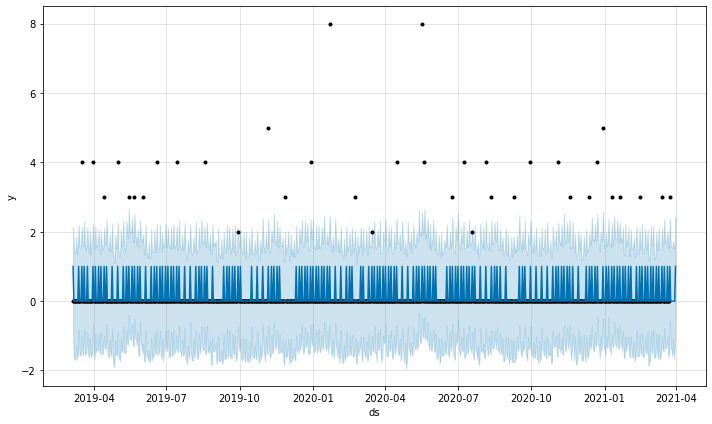

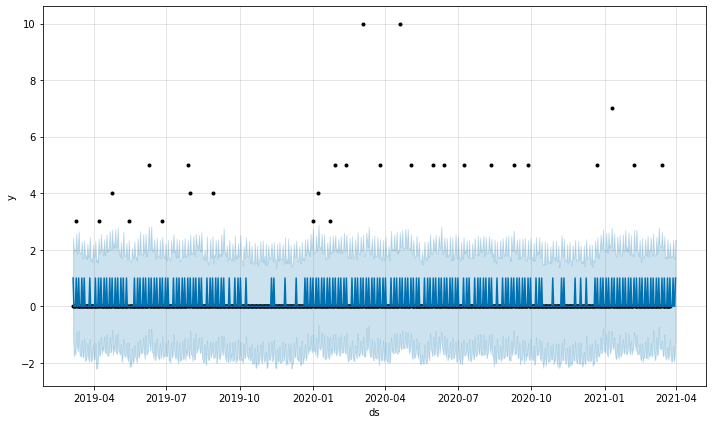

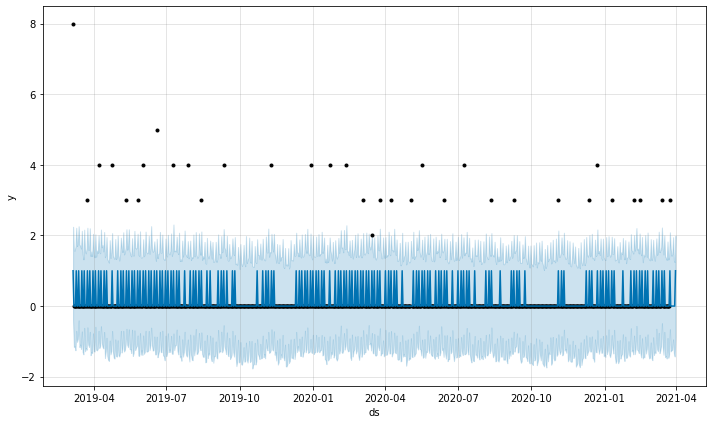

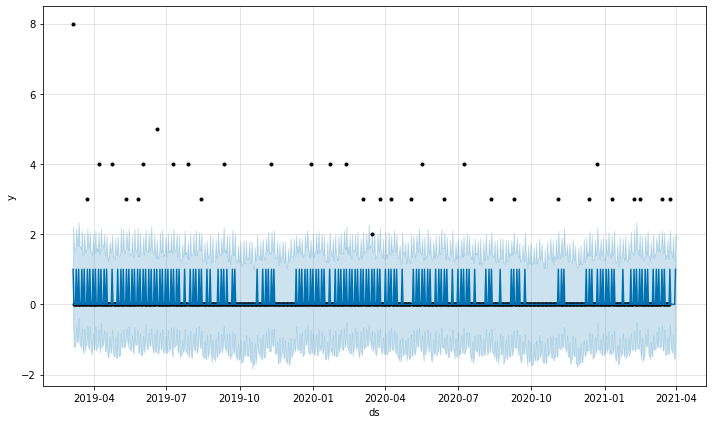

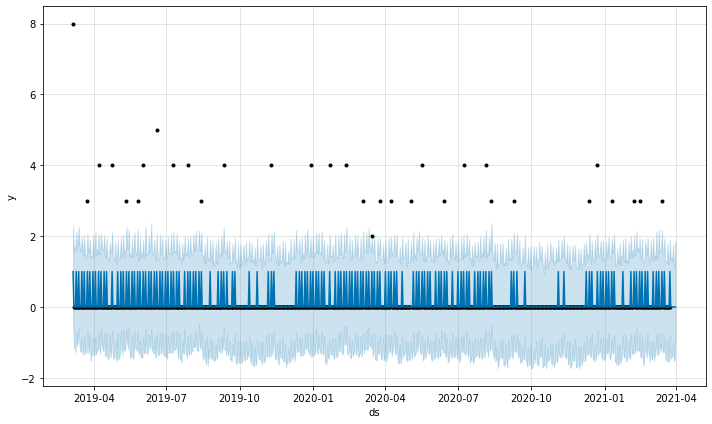

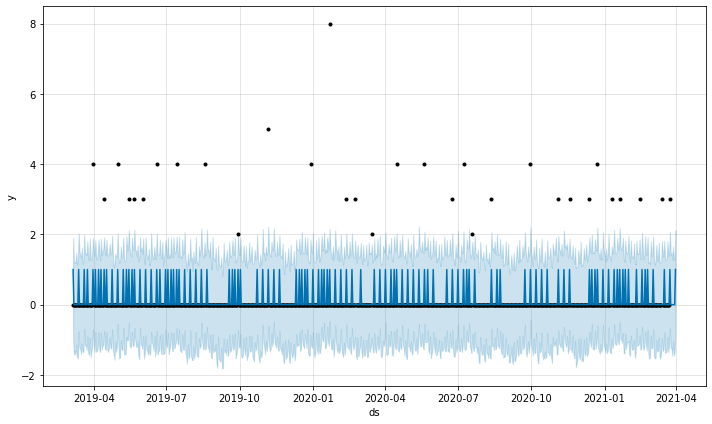

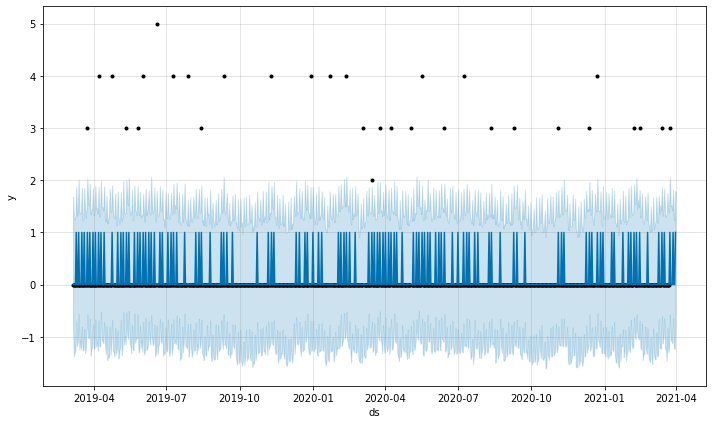

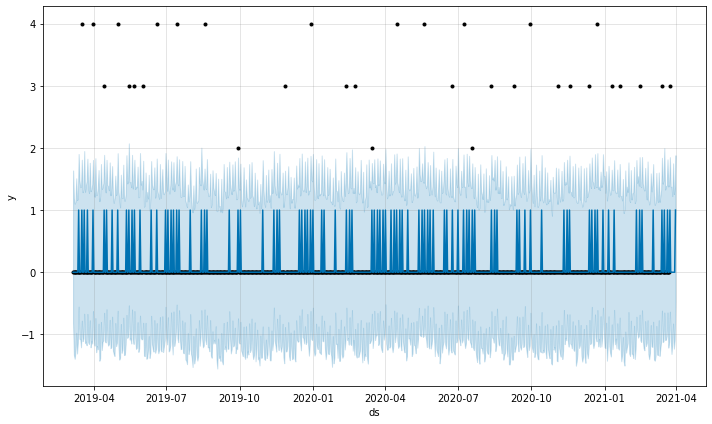

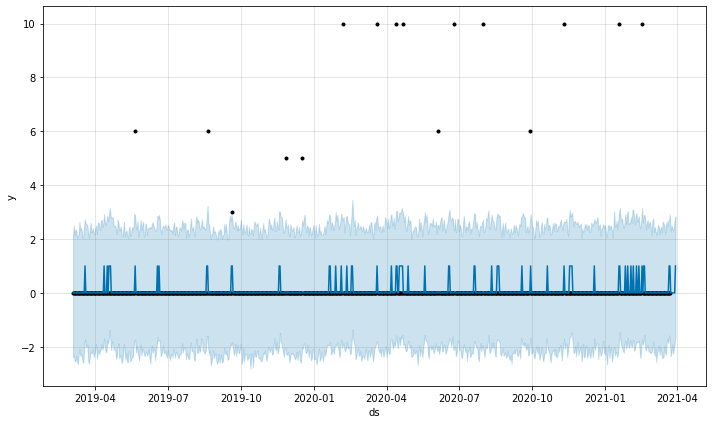

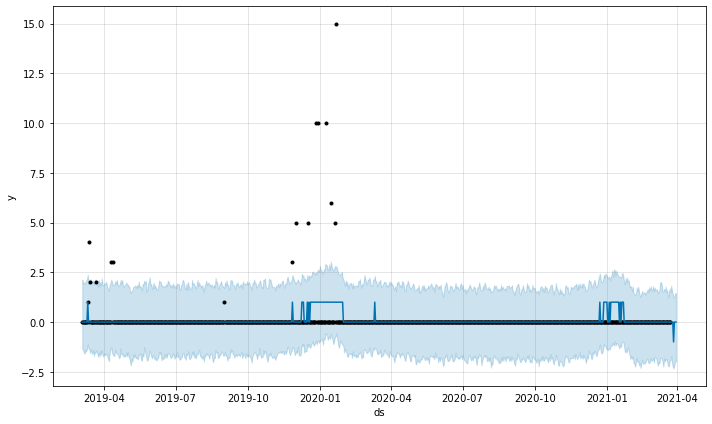

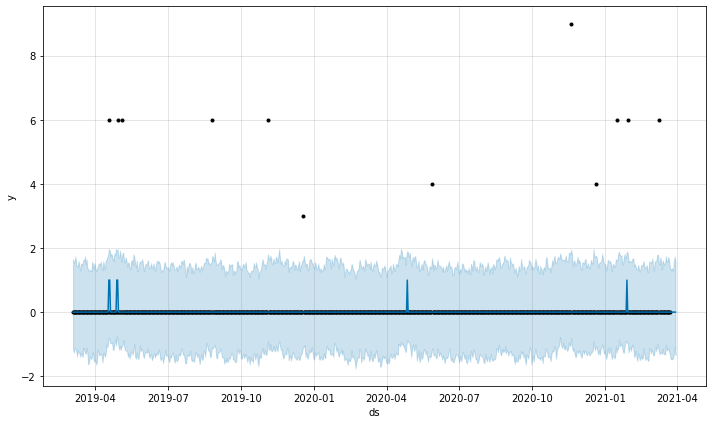

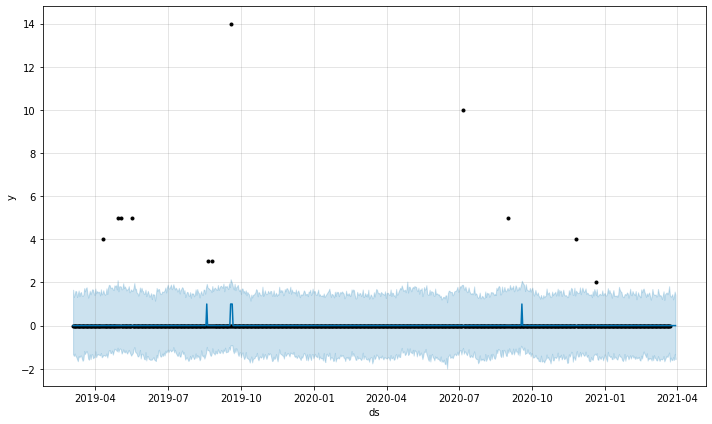

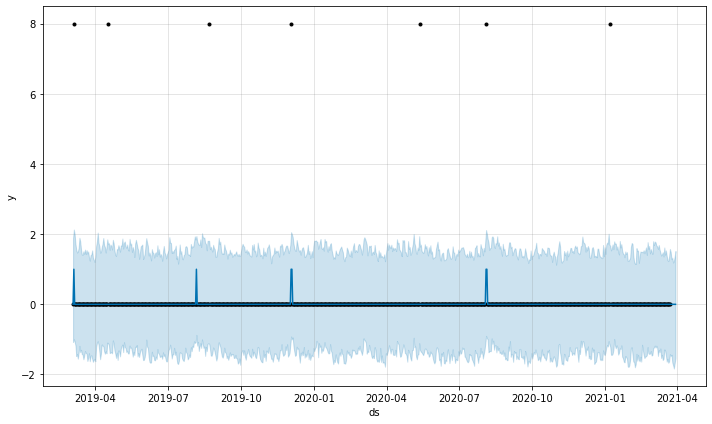

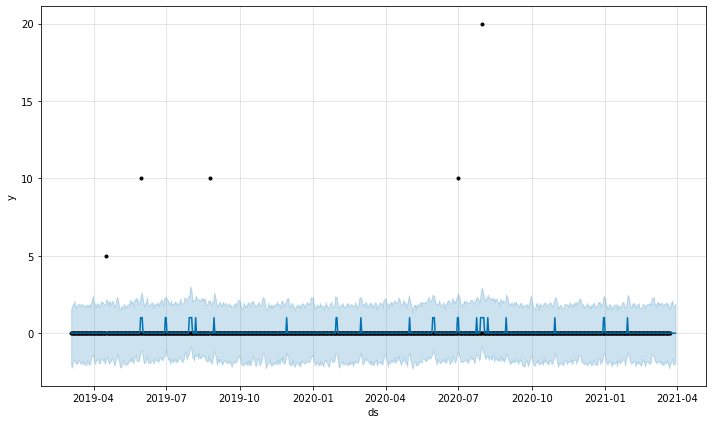

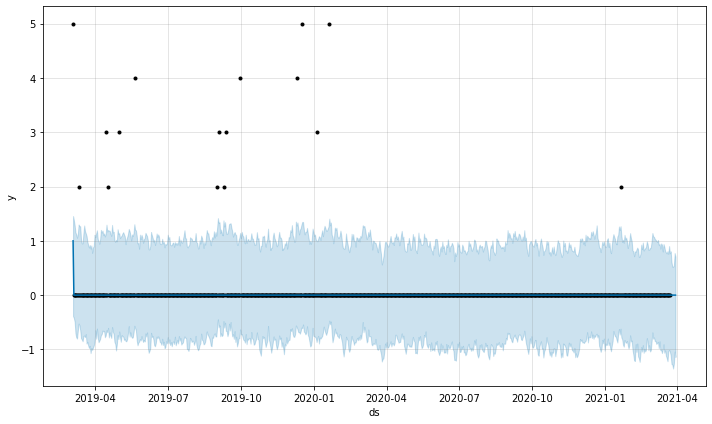

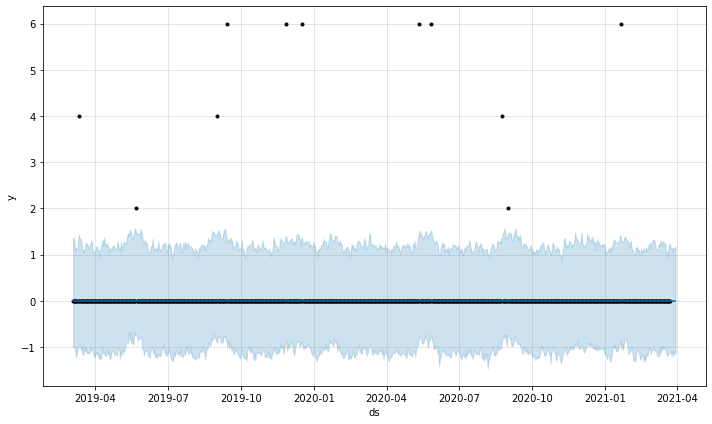

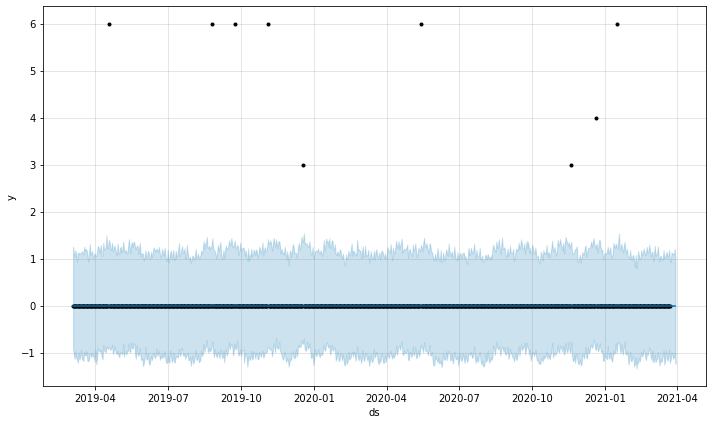

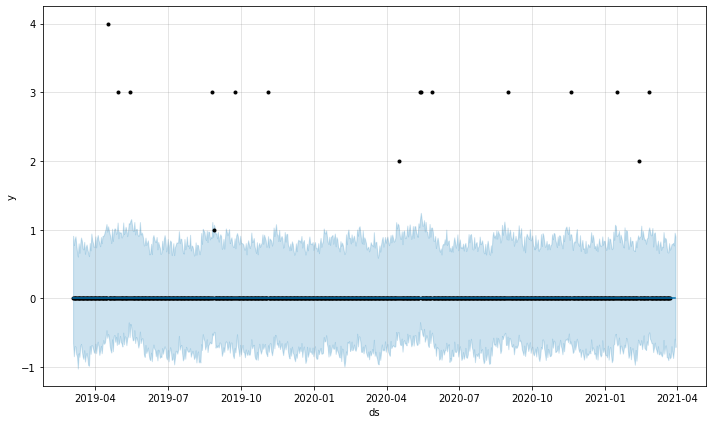

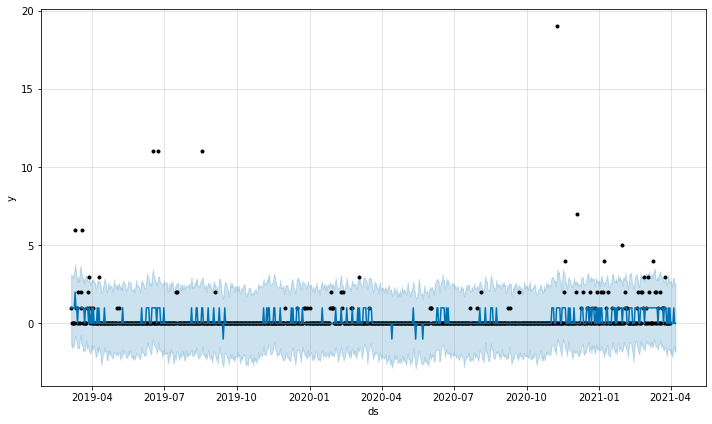

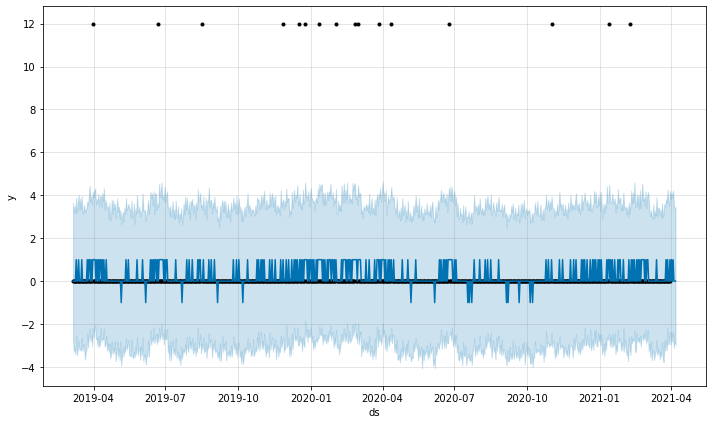

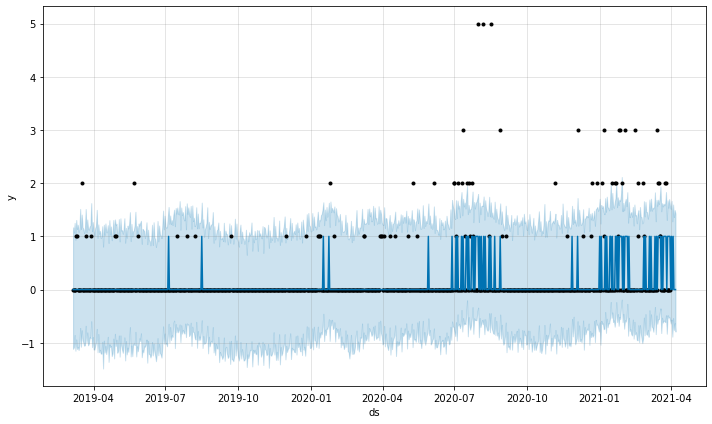

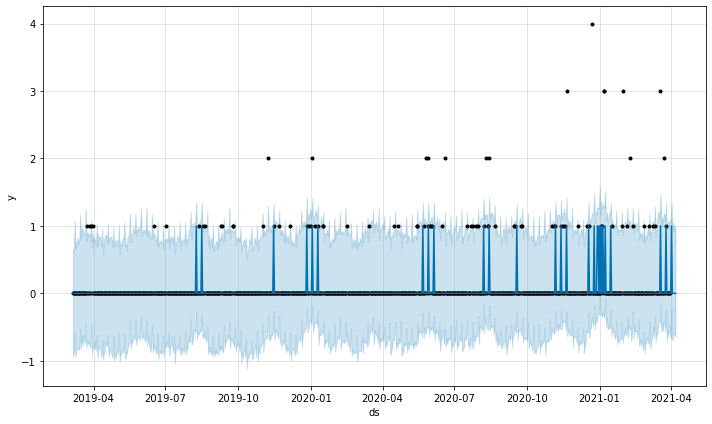

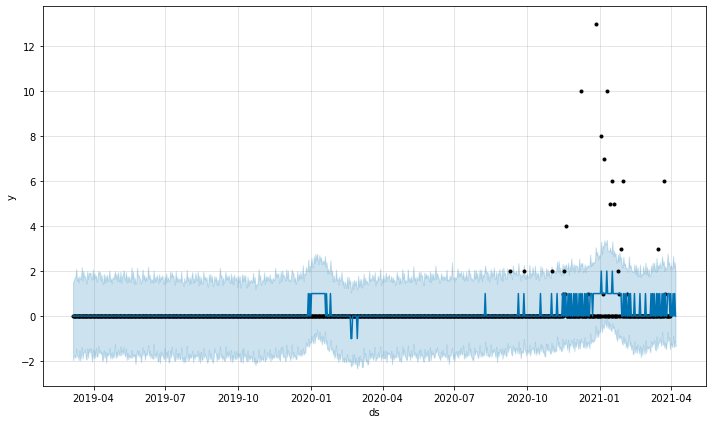

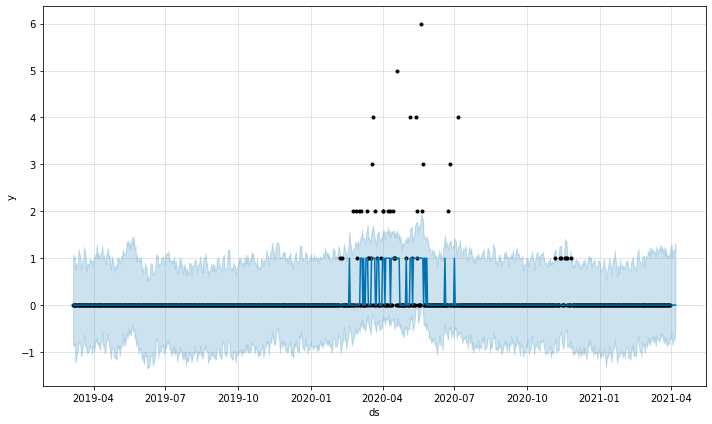

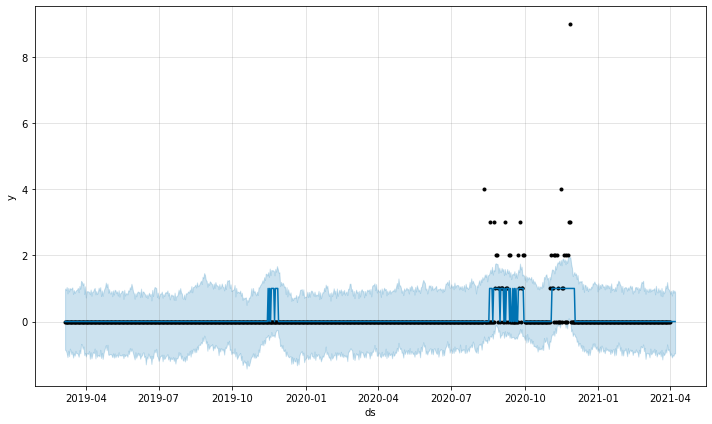

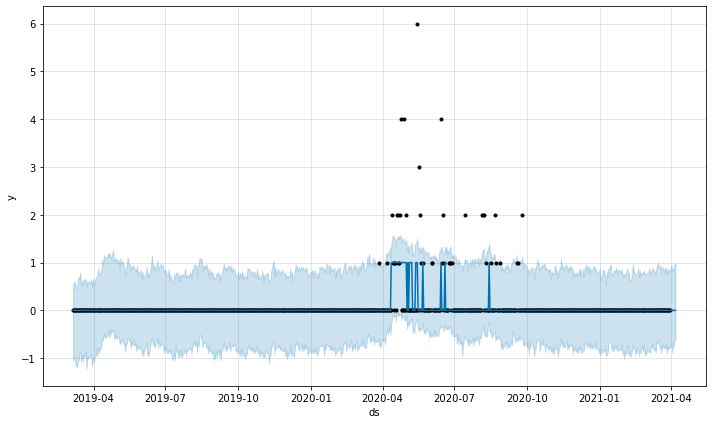

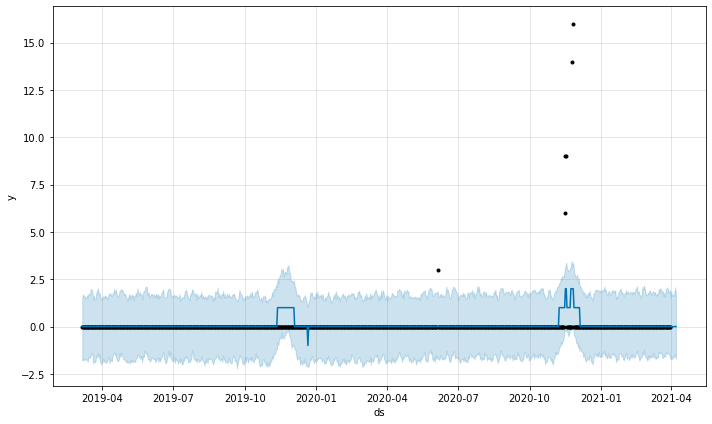

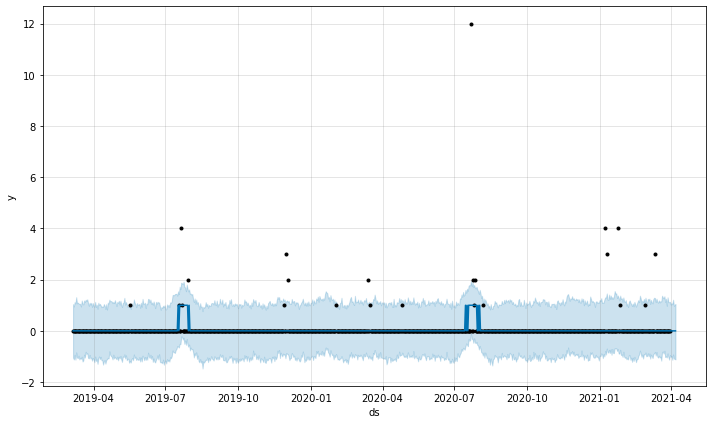

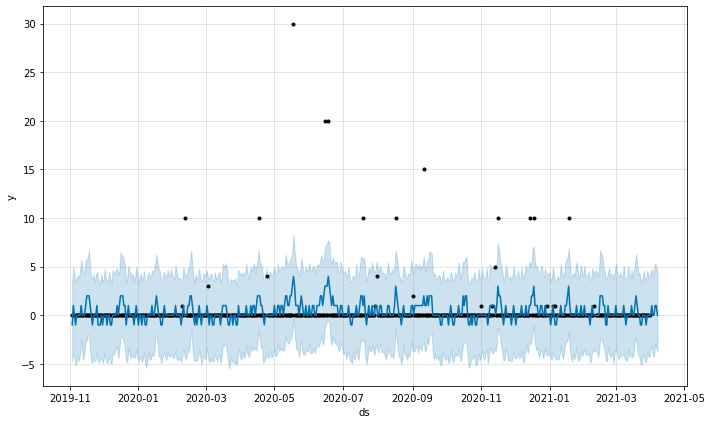

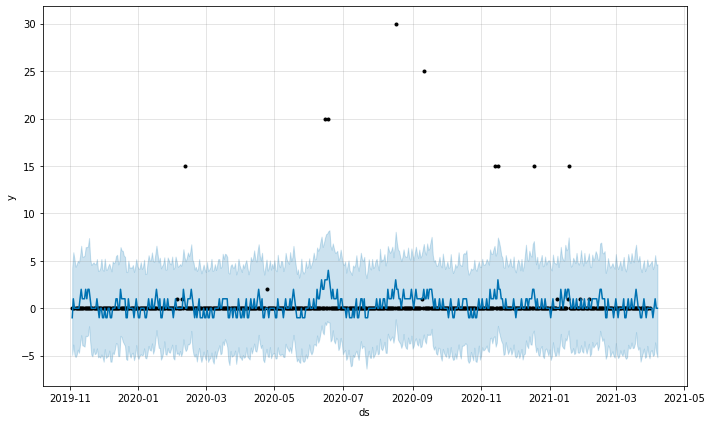

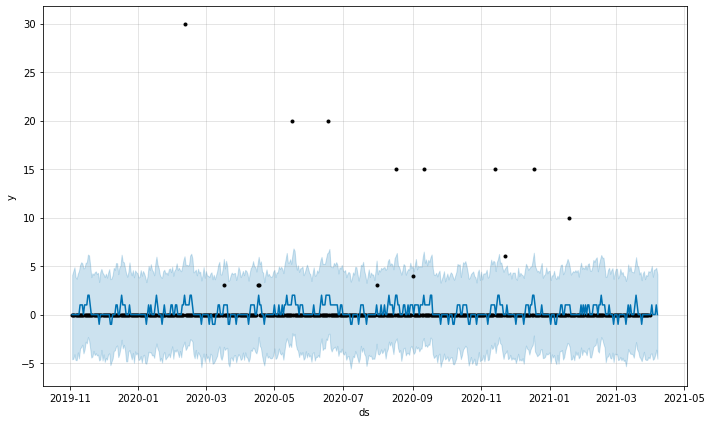

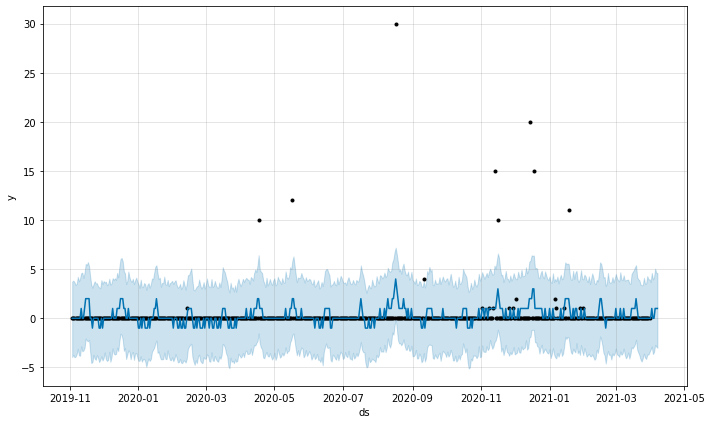

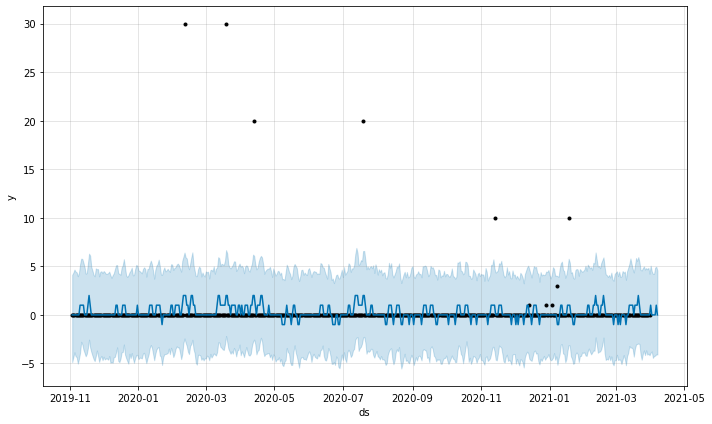

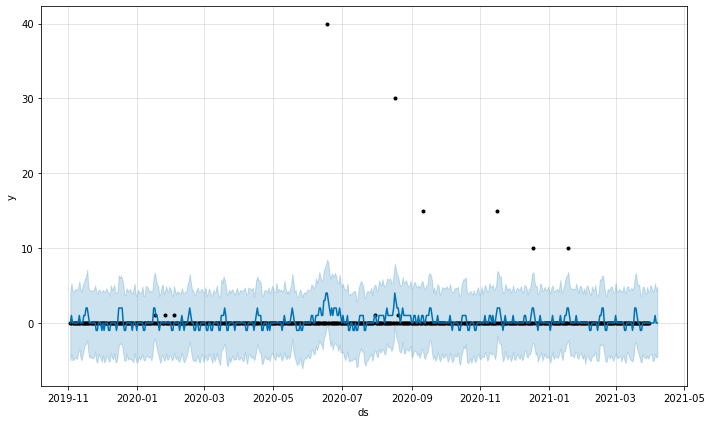

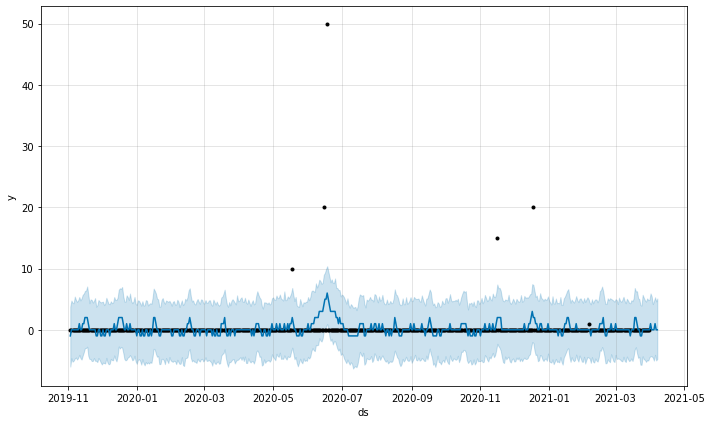

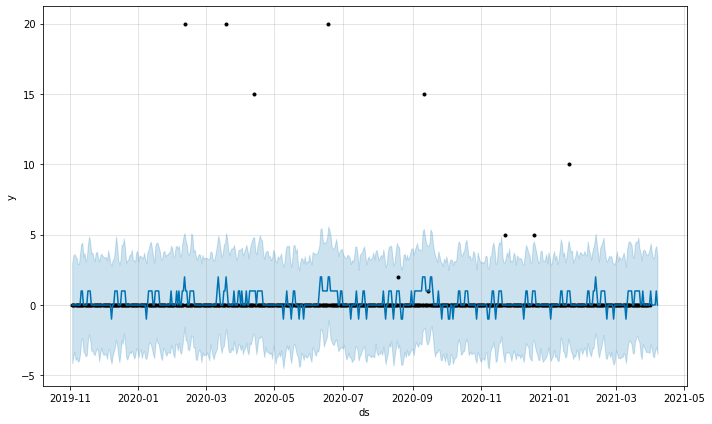

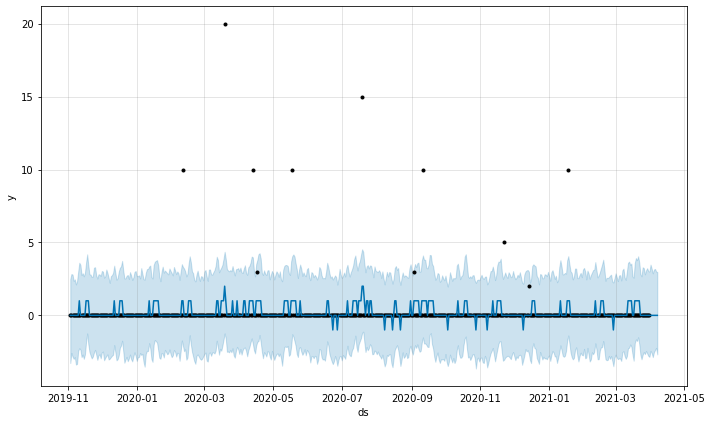

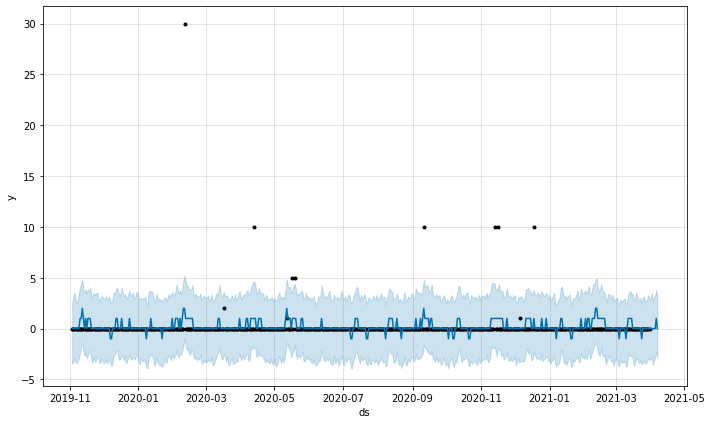

In [34]:
for store in stores_data:
    print(f'Store: {store}')
    for product in stores_data[store]['top_products_sales']:
        print(f'Product: {product}')
        stores_data[store]['fbp_objects'][product].plot(stores_data[store]['predictions'][product])


## Cross validation

In [64]:
for store in stores_data:
    print(f'Store: {store}')
    number_days_training = math.floor(stores_data[store]['number_of_days']*0.9)
    number_days_verification = stores_data[store]['number_of_days'] - number_days_training - 1
    stores_data[store]['cv'] = {}
    stores_data[store]['cv_p'] = {}
    for product in stores_data[store]['top_products_sales']:
        df_cv = cross_validation(stores_data[store]['fbp_objects'][product], initial=f"{number_days_training} days", horizon=f"{number_days_verification} days")
        df_p = performance_metrics(df_cv)
        stores_data[store]['cv'][product] = df_cv
        stores_data[store]['cv_p'][product] = df_p
        print(df_cv.head())
        print(df_p.head())

INFO:prophet:Making 1 forecasts with cutoffs between 2021-01-13 00:00:00 and 2021-01-13 00:00:00


Store: data/sales-7017139


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -2.645
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      69        1802.3    7.0407e-08       71.2189      0.2693           1       85   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 1 forecasts with cutoffs between 2021-01-13 00:00:00 and 2021-01-13 00:00:00


          ds      yhat  yhat_lower  yhat_upper  y     cutoff
0 2021-01-14  0.327394   -8.089375    7.922681  0 2021-01-13
1 2021-01-15  0.843054   -6.957778    9.502151  0 2021-01-13
2 2021-01-16  0.328069   -8.042852    8.666847  0 2021-01-13
3 2021-01-17  0.328405   -8.510450    8.910707  0 2021-01-13
4 2021-01-18  1.555811   -6.096202   10.370373  0 2021-01-13
  horizon       mse      rmse       mae  mdape  smape  coverage
0  7 days  0.524944  0.724530  0.578149    inf    2.0       1.0
1  8 days  0.525758  0.725092  0.579377    inf    2.0       1.0
2  9 days  0.527839  0.726525  0.580604    inf    2.0       1.0
3 10 days  0.528655  0.727086  0.581832    inf    2.0       1.0
4 11 days  0.529471  0.727648  0.583059    inf    2.0       1.0


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -2.78656
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1735.91    0.00019606       77.8338           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       1735.92   3.37142e-05       83.7526   3.614e-07       0.001      181  LS failed, Hessian reset 
     176       1735.93   5.32533e-08       71.3508      0.1813           1      264   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 1 forecasts with cutoffs between 2021-01-13 00:00:00 and 2021-01-13 00:00:00


          ds      yhat  yhat_lower  yhat_upper  y     cutoff
0 2021-01-14 -0.206300   -3.896355    3.401268  0 2021-01-13
1 2021-01-15  0.305995   -3.498820    4.128705  0 2021-01-13
2 2021-01-16 -0.207772   -4.087061    3.456355  0 2021-01-13
3 2021-01-17  0.099313   -3.406846    3.989492  0 2021-01-13
4 2021-01-18 -0.209068   -4.016356    3.661466  0 2021-01-13
  horizon       mse      rmse       mae  mdape  smape  coverage
0  7 days  0.035251  0.187751  0.168788    inf    2.0       1.0
1  8 days  0.035670  0.188865  0.169788    inf    2.0       1.0
2  9 days  0.035065  0.187257  0.168788    inf    2.0       1.0
3 10 days  0.035488  0.188382  0.169788    inf    2.0       1.0
4 11 days  0.035296  0.187872  0.168788    inf    2.0       1.0


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1888.17    2.7256e-06       60.9358      0.3541           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     134       1888.19   0.000121593       92.1099   1.483e-06       0.001      213  LS failed, Hessian reset 
     175        1888.2   1.28597e-07       64.6762      0.6437      0.9496      268   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 1 forecasts with cutoffs between 2021-01-13 00:00:00 and 2021-01-13 00:00:00


          ds      yhat  yhat_lower  yhat_upper  y     cutoff
0 2021-01-14 -0.289937   -8.035530    6.966385  0 2021-01-13
1 2021-01-15 -0.290590   -7.870316    6.679017  0 2021-01-13
2 2021-01-16 -0.291244   -7.982049    7.259413  0 2021-01-13
3 2021-01-17 -0.291899   -7.765346    6.733054  0 2021-01-13
4 2021-01-18  0.729305   -6.491432    7.944503  0 2021-01-13
  horizon       mse      rmse       mae  mdape  smape  coverage
0  7 days  0.148762  0.385696  0.353947    inf    2.0       1.0
1  8 days  0.149315  0.386414  0.354892    inf    2.0       1.0
2  9 days  0.149871  0.387131  0.355836    inf    2.0       1.0
3 10 days  0.150427  0.387849  0.356780    inf    2.0       1.0
4 11 days  0.150985  0.388567  0.357725    inf    2.0       1.0


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -3.4325
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1535.6   2.31116e-06       59.0645      0.2969      0.2969      147   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120        1535.6   2.55197e-06       70.3762   3.066e-08       0.001      214  LS failed, Hessian reset 
     126        1535.6    2.3199e-07       45.4387           1           1      223   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 1 forecasts with cutoffs between 2021-01-13 00:00:00 and 2021-01-13 00:00:00


          ds      yhat  yhat_lower  yhat_upper  y     cutoff
0 2021-01-14  0.548832   -2.007052    2.923985  0 2021-01-13
1 2021-01-15  0.126390   -2.253604    2.497966  0 2021-01-13
2 2021-01-16  0.023280   -2.610776    2.486583  0 2021-01-13
3 2021-01-17  0.023180   -2.496371    2.535430  0 2021-01-13
4 2021-01-18  0.278650   -2.332840    2.713664  0 2021-01-13
  horizon       mse      rmse       mae  mdape  smape  coverage
0  7 days  0.056719  0.238158  0.149659    inf    2.0       1.0
1  8 days  0.056746  0.238215  0.149684    inf    2.0       1.0
2  9 days  0.056753  0.238228  0.149708    inf    2.0       1.0
3 10 days  0.056754  0.238231  0.149733    inf    2.0       1.0
4 11 days  0.056755  0.238233  0.149758    inf    2.0       1.0


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -3.25
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      85       1577.26   1.21335e-07        57.982       0.333           1      124   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 1 forecasts with cutoffs between 2021-01-13 00:00:00 and 2021-01-13 00:00:00


          ds      yhat  yhat_lower  yhat_upper   y     cutoff
0 2021-01-14 -0.031730   -2.428671    2.211435   0 2021-01-13
1 2021-01-15 -0.135331   -2.531495    2.157227   0 2021-01-13
2 2021-01-16 -0.135772   -2.594262    2.151088   0 2021-01-13
3 2021-01-17 -0.136211   -2.223811    2.099133   0 2021-01-13
4 2021-01-18  0.169813   -2.159427    2.534015  10 2021-01-13
  horizon        mse      rmse       mae  mdape     smape  coverage
0  7 days  13.816012  3.716990  1.496133    inf  1.990458  0.857143
1  8 days  13.816052  3.716995  1.496726    inf  1.990458  0.857143
2  9 days  13.816215  3.717017  1.497320    inf  1.990458  0.857143
3 10 days  13.816379  3.717039  1.497913    inf  1.990458  0.857143
4 11 days  13.816543  3.717061  1.498507    inf  1.990458  0.857143


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -2.94444
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      74       1680.04   1.08482e-05       80.8397   1.518e-07       0.001      133  LS failed, Hessian reset 
      99       1680.05    1.4647e-07       56.3395      0.2895           1      177   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       1680.05   1.11394e-07       70.1621      0.1564       0.532      189   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 1 forecasts with cutoffs between 2021-01-13 00:00:00 and 2021-01-13 00:00:00


          ds      yhat  yhat_lower  yhat_upper  y     cutoff
0 2021-01-14  0.322165   -2.629209    3.218354  0 2021-01-13
1 2021-01-15  0.322765   -2.639415    3.395874  0 2021-01-13
2 2021-01-16  0.323363   -2.644046    3.363154  0 2021-01-13
3 2021-01-17  0.323960   -2.956565    3.172388  0 2021-01-13
4 2021-01-18  1.040156   -1.789176    4.053383  0 2021-01-13
  horizon       mse      rmse       mae  mdape  smape  coverage
0  7 days  0.244722  0.494694  0.426584    inf    2.0       1.0
1  8 days  0.245548  0.495528  0.427848    inf    2.0       1.0
2  9 days  0.246375  0.496362  0.429113    inf    2.0       1.0
3 10 days  0.247204  0.497196  0.430377    inf    2.0       1.0
4 11 days  0.248034  0.498031  0.431641    inf    2.0       1.0


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -4.21
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      94       1400.65   2.78728e-08       71.5066      0.6014      0.6014      121   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 1 forecasts with cutoffs between 2021-01-13 00:00:00 and 2021-01-13 00:00:00


          ds      yhat  yhat_lower  yhat_upper  y     cutoff
0 2021-01-14  0.165282   -1.290608    1.681452  0 2021-01-13
1 2021-01-15 -0.051730   -1.607390    1.387961  0 2021-01-13
2 2021-01-16 -0.052265   -1.667176    1.462224  0 2021-01-13
3 2021-01-17 -0.052798   -1.557040    1.457376  0 2021-01-13
4 2021-01-18  0.427355   -1.067337    1.999590  0 2021-01-13
  horizon       mse      rmse       mae  mdape  smape  coverage
0  7 days  0.031966  0.178790  0.122200    inf    2.0       1.0
1  8 days  0.031820  0.178382  0.121755    inf    2.0       1.0
2  9 days  0.031868  0.178515  0.122200    inf    2.0       1.0
3 10 days  0.031915  0.178649  0.122645    inf    2.0       1.0
4 11 days  0.031964  0.178784  0.123090    inf    2.0       1.0


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -3.74
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1473.22   5.48059e-07       79.7396      0.4972           1      147   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     109       1473.22   5.34903e-08       82.7834      0.2971      0.8344      159   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 1 forecasts with cutoffs between 2021-01-13 00:00:00 and 2021-01-13 00:00:00


          ds      yhat  yhat_lower  yhat_upper  y     cutoff
0 2021-01-14  0.034160   -1.242805    1.440672  0 2021-01-13
1 2021-01-15 -0.027830   -1.416258    1.338293  0 2021-01-13
2 2021-01-16 -0.027917   -1.380918    1.400524  0 2021-01-13
3 2021-01-17  0.033901   -1.234573    1.425213  0 2021-01-13
4 2021-01-18  0.339474   -1.106259    1.633054  0 2021-01-13
  horizon        mse      rmse       mae  mdape     smape  coverage
0  7 days   0.017287  0.131479  0.074950    inf  2.000000  1.000000
1  8 days  14.208095  3.769363  1.493896    inf  1.998108  0.857143
2  9 days  14.208103  3.769364  1.494031    inf  1.998108  0.857143
3 10 days  14.208111  3.769365  1.494167    inf  1.998108  0.857143
4 11 days  14.208102  3.769364  1.494031    inf  1.998108  0.857143


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -3.685
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      97       1487.42   1.95285e-05       103.158   2.047e-07       0.001      175  LS failed, Hessian reset 
      99       1487.42   1.32109e-05       87.8657      0.3602           1      178   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     153       1487.42   8.09135e-07       93.0101   7.953e-09       0.001      278  LS failed, Hessian reset 
     169       1487.42   2.52987e-08       99.0147      0.2997      0.2997      299   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 1 forecasts with cutoffs between 2021-01-13 00:00:00 and 2021-01-13 00:00:00


          ds      yhat  yhat_lower  yhat_upper  y     cutoff
0 2021-01-14  0.195439   -1.231720    1.505749  0 2021-01-13
1 2021-01-15  0.071721   -1.256322    1.458434  0 2021-01-13
2 2021-01-16  0.071717   -1.324113    1.441301  0 2021-01-13
3 2021-01-17  0.133571   -1.167138    1.458422  0 2021-01-13
4 2021-01-18  0.450016   -0.838033    1.821613  0 2021-01-13
  horizon       mse      rmse       mae  mdape  smape  coverage
0  7 days  0.039905  0.199763  0.152481    inf    2.0       1.0
1  8 days  0.039988  0.199969  0.152691    inf    2.0       1.0
2  9 days  0.040018  0.200045  0.152900    inf    2.0       1.0
3 10 days  0.040048  0.200121  0.153109    inf    2.0       1.0
4 11 days  0.040105  0.200261  0.153319    inf    2.0       1.0


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -2.59
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1834.01    1.0306e-05       92.2701           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     136       1834.01   1.06998e-07       88.1972      0.3564      0.9576      180   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 1 forecasts with cutoffs between 2020-07-23 00:00:00 and 2020-07-23 00:00:00


          ds      yhat  yhat_lower  yhat_upper   y     cutoff
0 2021-01-14  0.196680   -1.469061    1.841171   0 2021-01-13
1 2021-01-15 -0.072034   -1.653394    1.606396   0 2021-01-13
2 2021-01-16 -0.072729   -1.677182    1.550485   0 2021-01-13
3 2021-01-17 -0.073423   -1.668101    1.526180   0 2021-01-13
4 2021-01-18 -0.011960   -1.666315    1.577644  30 2021-01-13
  horizon         mse       rmse       mae  mdape  smape  coverage
0  7 days  128.683332  11.343868  4.367904    inf    2.0  0.857143
1  8 days  128.683074  11.343856  4.367238    inf    2.0  0.857143
2  9 days  128.683173  11.343861  4.367904    inf    2.0  0.857143
3 10 days  128.683272  11.343865  4.368569    inf    2.0  0.857143
4 11 days  128.683373  11.343869  4.369234    inf    2.0  0.857143
Store: data/sales-7003984


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      57       883.586   9.60337e-06       61.2131   1.707e-07       0.001      115  LS failed, Hessian reset 
      92       883.589   8.36949e-08       50.1345      0.7068      0.7068      166   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 1 forecasts with cutoffs between 2020-07-23 00:00:00 and 2020-07-23 00:00:00


          ds      yhat  yhat_lower  yhat_upper  y     cutoff
0 2020-07-24  0.408802  -22.026535   22.341427  0 2020-07-23
1 2020-07-25 -0.980744  -23.592773   20.343929  0 2020-07-23
2 2020-07-26 -0.994234  -22.474609   19.472494  0 2020-07-23
3 2020-07-27  3.117129  -18.263841   24.520691  0 2020-07-23
4 2020-07-28 -0.994034  -21.458110   21.469653  0 2020-07-23
  horizon       mse      rmse       mae  mdape  smape  coverage
0  5 days  2.564415  1.601379  1.298989    inf    2.0       1.0
1  6 days  2.559339  1.599794  1.292525    inf    2.0       1.0
2  7 days  2.395330  1.547685  1.171692    inf    2.0       1.0
3  8 days  2.227116  1.492353  1.049640    inf    2.0       1.0
4  9 days  0.486054  0.697176  0.627329    inf    2.0       1.0


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -6.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       783.478   4.79804e-07       98.0791       0.402           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102       783.478   4.82135e-07       100.012   5.208e-09       0.001      178  LS failed, Hessian reset 
     112       783.478   2.01105e-08       94.3215     0.03637           1      191   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 1 forecasts with cutoffs between 2020-07-23 00:00:00 and 2020-07-23 00:00:00


          ds      yhat  yhat_lower  yhat_upper  y     cutoff
0 2020-07-24 -0.194749   -2.601307    2.283059  0 2020-07-23
1 2020-07-25 -0.194719   -2.490382    2.200679  0 2020-07-23
2 2020-07-26 -0.060372   -2.640607    2.544455  0 2020-07-23
3 2020-07-27  0.076713   -2.456858    2.440562  0 2020-07-23
4 2020-07-28  0.213798   -2.491882    2.755940  0 2020-07-23
  horizon       mse      rmse       mae  mdape  smape  coverage
0  5 days  0.026216  0.161915  0.148070    inf    2.0       1.0
1  6 days  0.026421  0.162545  0.148591    inf    2.0       1.0
2  7 days  0.027984  0.167284  0.152418    inf    2.0       1.0
3  8 days  0.035263  0.187783  0.180362    inf    2.0       1.0
4  9 days  0.042091  0.205160  0.205032    inf    2.0       1.0


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -3.28125
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      65       1099.66   6.36457e-05       79.9118   7.557e-07       0.001      124  LS failed, Hessian reset 
      99       1099.66   3.46595e-08       76.4045      0.7366      0.7366      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102       1099.66   2.97146e-08       76.2834      0.2838           1      169   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 1 forecasts with cutoffs between 2020-07-23 00:00:00 and 2020-07-23 00:00:00


          ds      yhat  yhat_lower  yhat_upper  y     cutoff
0 2020-07-24 -0.222206   -3.054810    2.599521  0 2020-07-23
1 2020-07-25 -0.222363   -3.033262    2.333350  0 2020-07-23
2 2020-07-26 -0.224685   -3.037423    2.538764  0 2020-07-23
3 2020-07-27 -0.019451   -2.726688    3.040098  0 2020-07-23
4 2020-07-28  0.048852   -2.708300    2.743481  0 2020-07-23
  horizon       mse      rmse       mae  mdape  smape  coverage
0  5 days  0.030414  0.174395  0.147511    inf    2.0       1.0
1  6 days  0.022096  0.148647  0.120718    inf    2.0       1.0
2  7 days  0.019086  0.138153  0.113338    inf    2.0       1.0
3  8 days  0.019438  0.139419  0.114113    inf    2.0       1.0
4  9 days  0.029824  0.172697  0.155967    inf    2.0       1.0


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -2.625
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      55       1280.65    9.3449e-05       98.0049    8.46e-07       0.001      111  LS failed, Hessian reset 
      99       1280.65   3.94429e-07       65.3848      0.4801      0.4801      180   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     174       1280.67   3.49045e-08       70.3842      0.2838           1      286   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 1 forecasts with cutoffs between 2020-07-23 00:00:00 and 2020-07-23 00:00:00


          ds      yhat  yhat_lower  yhat_upper  y     cutoff
0 2020-07-24  0.511471   -1.412214    2.475773  0 2020-07-23
1 2020-07-25  0.236158   -1.701897    2.077608  0 2020-07-23
2 2020-07-26  0.238267   -1.619544    2.213052  0 2020-07-23
3 2020-07-27  0.239035   -1.586134    2.186260  0 2020-07-23
4 2020-07-28  0.239799   -1.600953    2.125198  0 2020-07-23
  horizon       mse      rmse       mae  mdape  smape  coverage
0  5 days  0.097757  0.312661  0.292946    inf    2.0       1.0
1  6 days  0.073747  0.271565  0.265899    inf    2.0       1.0
2  7 days  0.074241  0.272471  0.266932    inf    2.0       1.0
3  8 days  0.117243  0.342408  0.323545    inf    2.0       1.0
4  9 days  0.117921  0.343396  0.324941    inf    2.0       1.0


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -4.54167
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      57       926.135   0.000112955       76.0217   1.308e-06       0.001      101  LS failed, Hessian reset 
      99       926.144   5.06408e-06       72.7301           1           1      153   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     122       926.144   3.81602e-09       70.8002     0.05519     0.05519      193   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 1 forecasts with cutoffs between 2020-07-23 00:00:00 and 2020-07-23 00:00:00


          ds      yhat  yhat_lower  yhat_upper  y     cutoff
0 2020-07-24 -0.197100   -2.524351    2.097508  0 2020-07-23
1 2020-07-25 -0.197056   -2.370186    2.360960  0 2020-07-23
2 2020-07-26  0.101342   -2.348663    2.419158  0 2020-07-23
3 2020-07-27 -0.035514   -2.356454    2.254427  0 2020-07-23
4 2020-07-28  0.101428   -2.341637    2.552142  0 2020-07-23
  horizon       mse      rmse       mae  mdape  smape  coverage
0  5 days  0.019900  0.141066  0.126488    inf    2.0       1.0
1  6 days  0.012919  0.113662  0.099629    inf    2.0       1.0
2  7 days  0.013126  0.114568  0.100151    inf    2.0       1.0
3  8 days  0.019259  0.138776  0.120347    inf    2.0       1.0
4  9 days  0.027190  0.164893  0.153700    inf    2.0       1.0


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -9
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       671.105    2.1913e-08       93.1597      0.6022      0.6022      123   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 1 forecasts with cutoffs between 2020-07-23 00:00:00 and 2020-07-23 00:00:00


          ds      yhat  yhat_lower  yhat_upper  y     cutoff
0 2020-07-24  0.090139   -1.430983    1.557509  0 2020-07-23
1 2020-07-25 -0.048554   -1.576295    1.513650  0 2020-07-23
2 2020-07-26  0.224240   -1.281860    1.709000  0 2020-07-23
3 2020-07-27  0.155915   -1.460853    1.767907  0 2020-07-23
4 2020-07-28  0.156001   -1.455422    1.804334  0 2020-07-23
  horizon       mse      rmse       mae  mdape  smape  coverage
0  5 days  0.021882  0.147927  0.134970    inf    2.0       1.0
1  6 days  0.021795  0.147631  0.134477    inf    2.0       1.0
2  7 days  0.021805  0.147664  0.134579    inf    2.0       1.0
3  8 days  0.013326  0.115437  0.107494    inf    2.0       1.0
4  9 days  0.008961  0.094664  0.086287    inf    2.0       1.0


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -6.375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      96       795.222   3.38835e-08       81.7278      0.3813           1      129   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 1 forecasts with cutoffs between 2020-07-23 00:00:00 and 2020-07-23 00:00:00


          ds      yhat  yhat_lower  yhat_upper  y     cutoff
0 2020-07-24  0.028597   -1.458836    1.444616  0 2020-07-23
1 2020-07-25 -0.039910   -1.485958    1.571122  0 2020-07-23
2 2020-07-26  0.094690   -1.265018    1.500800  0 2020-07-23
3 2020-07-27  0.000300   -1.502015    1.551800  0 2020-07-23
4 2020-07-28  0.377324   -1.107407    1.832430  0 2020-07-23
  horizon       mse      rmse       mae  mdape  smape  coverage
0  5 days  0.030750  0.175357  0.108164    inf    2.0       1.0
1  6 days  0.034219  0.184985  0.129400    inf    2.0       1.0
2  7 days  0.035206  0.187634  0.137577    inf    2.0       1.0
3  8 days  0.033564  0.183205  0.124130    inf    2.0       1.0
4  9 days  0.033901  0.184122  0.132280    inf    2.0       1.0


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1061.05   3.24916e-07       99.3721      0.4864      0.4864      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       1061.05   4.67595e-06       95.4287   4.747e-08       0.001      196  LS failed, Hessian reset 
     162       1061.05   1.93038e-07       91.5559   1.716e-09       0.001      293  LS failed, Hessian reset 
     167       1061.05   4.01692e-08       82.0097       0.318      0.9309      299   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 1 forecasts with cutoffs between 2020-07-23 00:00:00 and 2020-07-23 00:00:00


          ds      yhat  yhat_lower  yhat_upper  y     cutoff
0 2020-07-24 -0.026264   -1.482130    1.392248  0 2020-07-23
1 2020-07-25 -0.026266   -1.580933    1.485911  0 2020-07-23
2 2020-07-26  0.247961   -1.272099    1.703830  0 2020-07-23
3 2020-07-27  0.042021   -1.399765    1.473808  0 2020-07-23
4 2020-07-28 -0.026628   -1.348575    1.461732  0 2020-07-23
  horizon       mse      rmse       mae  mdape  smape  coverage
0  5 days  0.013068  0.114315  0.073828    inf    2.0       1.0
1  6 days  0.019360  0.139141  0.104437    inf    2.0       1.0
2  7 days  0.021671  0.147212  0.121316    inf    2.0       1.0
3  8 days  0.009520  0.097570  0.077119    inf    2.0       1.0
4  9 days  0.009312  0.096501  0.074111    inf    2.0       1.0


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -4.14
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       971.289    4.0758e-05       73.1514           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       971.315   0.000205596         85.14   1.998e-06       0.001      178  LS failed, Hessian reset 
     156       971.321   4.77242e-08        77.996      0.3291           1      235   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 1 forecasts with cutoffs between 2020-07-23 00:00:00 and 2020-07-23 00:00:00


          ds      yhat  yhat_lower  yhat_upper  y     cutoff
0 2020-07-24  0.057692   -1.528393    1.884998  0 2020-07-23
1 2020-07-25 -0.107836   -1.902865    1.651775  0 2020-07-23
2 2020-07-26 -0.055956   -1.806391    1.698133  0 2020-07-23
3 2020-07-27  0.026146   -1.765576    1.846858  0 2020-07-23
4 2020-07-28  0.203655   -1.556620    1.908011  0 2020-07-23
  horizon       mse      rmse       mae  mdape  smape  coverage
0  5 days  0.012049  0.109770  0.090257    inf    2.0       1.0
1  6 days  0.012326  0.111021  0.092445    inf    2.0       1.0
2  7 days  0.010150  0.100749  0.076363    inf    2.0       1.0
3  8 days  0.010143  0.100712  0.076295    inf    2.0       1.0
4  9 days  0.012422  0.111455  0.093048    inf    2.0       1.0


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -3.75
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      92       1021.53   9.43993e-05       52.8097   1.165e-06       0.001      149  LS failed, Hessian reset 
      99       1021.54    6.3075e-05       44.0332           1           1      159   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     153       1021.54   1.88754e-06       64.3956   2.293e-08       0.001      276  LS failed, Hessian reset 
     165       1021.54   1.39112e-08       59.7943     0.06725           1      294   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 1 forecasts with cutoffs between 2021-01-07 00:00:00 and 2021-01-07 00:00:00


          ds      yhat  yhat_lower  yhat_upper  y     cutoff
0 2020-07-24  0.044823   -1.534427    1.654323  0 2020-07-23
1 2020-07-25 -0.024115   -1.600271    1.511522  0 2020-07-23
2 2020-07-26 -0.025697   -1.558268    1.503267  0 2020-07-23
3 2020-07-27  0.111521   -1.510237    1.778901  0 2020-07-23
4 2020-07-28  0.317136   -1.227164    1.912819  0 2020-07-23
  horizon       mse      rmse       mae  mdape  smape  coverage
0  5 days  0.023253  0.152488  0.104658    inf    2.0       1.0
1  6 days  0.022970  0.151560  0.100586    inf    2.0       1.0
2  7 days  0.022970  0.151558  0.100573    inf    2.0       1.0
3  8 days  0.023248  0.152474  0.104496    inf    2.0       1.0
4  9 days  0.020873  0.144474  0.086917    inf    2.0       1.0
Store: data/sales-7023126


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -6.515
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79       1131.51   3.53264e-05       93.4429   4.082e-07       0.001      162  LS failed, Hessian reset 
      99       1131.51   4.92996e-07       68.9628      0.5504      0.5504      192   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1131.58   2.54319e-07       87.3783     0.07302     0.07302      329   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     248       1131.59   2.89802e-08       76.9808      0.2254           1      393   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 1 forecasts with cutoffs between 2021-01-07 00:00:00 and 2021-01-07 00:00:00


          ds      yhat  yhat_lower  yhat_upper  y     cutoff
0 2021-01-08  0.345221   -1.935881    2.405477  0 2021-01-07
1 2021-01-09  0.045572   -2.113277    2.231342  0 2021-01-07
2 2021-01-10  0.045388   -2.192702    2.203684  0 2021-01-07
3 2021-01-11  0.209728   -1.973978    2.376266  0 2021-01-07
4 2021-01-12  0.362614   -1.872653    2.650087  0 2021-01-07
  horizon        mse      rmse       mae  mdape     smape  coverage
0  7 days   0.055194  0.234933  0.202407    inf  2.000000  1.000000
1  8 days   0.055187  0.234919  0.202397    inf  2.000000  1.000000
2  9 days   0.055186  0.234917  0.202387    inf  2.000000  1.000000
3 10 days   0.055185  0.234915  0.202377    inf  2.000000  1.000000
4 11 days  13.741871  3.707003  1.571036    inf  1.988266  0.857143


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -3.53111
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      89       1498.56   0.000253469       136.391   2.335e-06       0.001      163  LS failed, Hessian reset 
      99       1498.58   2.92887e-05        63.067      0.2715           1      174   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       1498.59   3.21357e-05       80.1586   4.208e-07       0.001      270  LS failed, Hessian reset 
     169       1498.59    7.0414e-06       52.2538   6.671e-08       0.001      357  LS failed, Hessian reset 
     194       1498.59   2.53635e-08       85.6298     0.04916           1      393   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 1 forecasts with cutoffs between 2021-01-07 00:00:00 and 2021-01-07 00:00:00


          ds      yhat  yhat_lower  yhat_upper  y     cutoff
0 2021-01-08 -0.103415   -2.006521    1.741746  0 2021-01-07
1 2021-01-09 -0.240555   -1.989098    1.664511  0 2021-01-07
2 2021-01-10 -0.230942   -2.180495    1.738249  0 2021-01-07
3 2021-01-11 -0.023940   -2.009040    1.954066  0 2021-01-07
4 2021-01-12 -0.149083   -2.054119    1.746345  0 2021-01-07
  horizon       mse      rmse       mae  mdape  smape  coverage
0  7 days  0.022261  0.149202  0.126202    inf    2.0       1.0
1  8 days  0.022495  0.149984  0.127294    inf    2.0       1.0
2  9 days  0.023029  0.151752  0.128385    inf    2.0       1.0
3 10 days  0.023541  0.153431  0.129476    inf    2.0       1.0
4 11 days  0.023602  0.153628  0.130567    inf    2.0       1.0


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -3.8642
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      66       1429.56    0.00013149       64.5312   2.058e-06       0.001      126  LS failed, Hessian reset 
      99       1429.57   4.05834e-05        80.786           1           1      177   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     122       1429.57   5.90453e-06       64.0851    1.26e-07       0.001      254  LS failed, Hessian reset 
     141       1429.57   1.98642e-08       60.3313     0.04507           1      288   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 1 forecasts with cutoffs between 2021-01-07 00:00:00 and 2021-01-07 00:00:00


          ds      yhat  yhat_lower  yhat_upper  y     cutoff
0 2021-01-08  0.010806   -1.327914    1.333120  0 2021-01-07
1 2021-01-09  0.011082   -1.312753    1.327952  0 2021-01-07
2 2021-01-10  0.115551   -1.251756    1.380435  0 2021-01-07
3 2021-01-11  0.196610   -1.083128    1.535083  0 2021-01-07
4 2021-01-12  0.011268   -1.419108    1.329186  0 2021-01-07
  horizon       mse      rmse       mae  mdape     smape  coverage
0  7 days  0.013905  0.117922  0.085078    inf  2.000000  1.000000
1  8 days  5.135833  2.266238  0.938933    inf  1.998839  0.857143
2  9 days  5.135838  2.266239  0.939133    inf  1.998839  0.857143
3 10 days  5.135885  2.266249  0.939334    inf  1.998839  0.857143
4 11 days  5.135964  2.266267  0.939535    inf  1.998839  0.857143


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -3.14796
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      62       1591.57   0.000117067       87.2865   1.123e-06       0.001      123  LS failed, Hessian reset 
      77       1591.58   5.62702e-06       77.5544   7.803e-08       0.001      176  LS failed, Hessian reset 
      99       1591.58   4.01059e-07       80.1342      0.8859      0.8859      210   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     109       1591.58   2.14081e-08       76.9071      0.2556           1      224   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 1 forecasts with cutoffs between 2021-01-07 00:00:00 and 2021-01-07 00:00:00


          ds      yhat  yhat_lower  yhat_upper  y     cutoff
0 2021-01-08  0.083276   -1.512308    1.775208  0 2021-01-07
1 2021-01-09 -0.020707   -1.516712    1.583250  0 2021-01-07
2 2021-01-10  0.000310   -1.574142    1.585221  0 2021-01-07
3 2021-01-11  0.215952   -1.342322    1.708976  0 2021-01-07
4 2021-01-12 -0.020981   -1.626918    1.504203  0 2021-01-07
  horizon       mse      rmse       mae  mdape  smape  coverage
0  7 days  0.011189  0.105778  0.079651    inf    2.0       1.0
1  8 days  0.011195  0.105805  0.079685    inf    2.0       1.0
2  9 days  0.011193  0.105798  0.079651    inf    2.0       1.0
3 10 days  0.011193  0.105798  0.079685    inf    2.0       1.0
4 11 days  0.011208  0.105867  0.079719    inf    2.0       1.0


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -115.129
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      90       1204.85    0.00090677       182.207   8.317e-06       0.001      155  LS failed, Hessian reset 
      99       1206.86    0.00161346       98.6285      0.7332      0.7332      166   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     150       1210.67    0.00250967       319.225    1.56e-05       0.001      264  LS failed, Hessian reset 
     199       1213.04   0.000869868       81.6965      0.7453      0.7453      323   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     237       1214.01   0.000596373       141.681   4.613e-06       0.001      422  LS failed, Hessian reset 
     299       1215.42   2.19963e-06       56.2997      0.5623      0.5623      503   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 1 forecasts with cutoffs between 2021-01-07 00:00:00 and 2021-01-07 00:00:00


          ds      yhat  yhat_lower  yhat_upper  y     cutoff
0 2021-01-08 -0.023545   -1.726734    1.546255  0 2021-01-07
1 2021-01-09 -0.023545   -1.633941    1.640541  0 2021-01-07
2 2021-01-10 -0.023545   -1.521109    1.538983  0 2021-01-07
3 2021-01-11 -0.023787   -1.626047    1.447761  0 2021-01-07
4 2021-01-12  0.223633   -1.334966    1.731538  0 2021-01-07
  horizon       mse      rmse       mae  mdape  smape  coverage
0  7 days  0.013156  0.114700  0.085768    inf    2.0       1.0
1  8 days  0.013159  0.114714  0.085833    inf    2.0       1.0
2  9 days  0.013162  0.114727  0.085898    inf    2.0       1.0
3 10 days  0.013165  0.114741  0.085963    inf    2.0       1.0
4 11 days  0.013169  0.114754  0.086028    inf    2.0       1.0


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -2.90625
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1667.48    8.7423e-08       85.0501       0.192           1      132   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 1 forecasts with cutoffs between 2021-01-07 00:00:00 and 2021-01-07 00:00:00


          ds      yhat  yhat_lower  yhat_upper  y     cutoff
0 2021-01-08  0.198460   -1.997657    2.105783  0 2021-01-07
1 2021-01-09 -0.009739   -1.997492    2.123163  0 2021-01-07
2 2021-01-10  0.094303   -1.834640    2.099691  0 2021-01-07
3 2021-01-11 -0.009849   -2.013958    1.905119  0 2021-01-07
4 2021-01-12 -0.009887   -2.006790    2.061602  0 2021-01-07
  horizon       mse      rmse       mae  mdape  smape  coverage
0  7 days  0.011161  0.105647  0.079980    inf    2.0       1.0
1  8 days  0.011139  0.105542  0.079924    inf    2.0       1.0
2  9 days  0.011140  0.105547  0.079980    inf    2.0       1.0
3 10 days  0.011130  0.105497  0.079924    inf    2.0       1.0
4 11 days  0.011131  0.105502  0.079980    inf    2.0       1.0


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -110.995
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1199.01     0.0208507       252.684           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     151        1205.1    0.00168434       249.511   1.459e-05       0.001      223  LS failed, Hessian reset 
     199       1206.32   1.77438e-05       94.1268      0.9035      0.9035      281   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     263       1206.83    0.00408628       310.857   4.091e-05       0.001      434  LS failed, Hessian reset 
     299       1207.64   9.66597e-05       91.5339      0.5208      0.5208      477   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     390        1207.7   3.64479e-08       95.7239       0.286           1      587   
Optimization terminat

INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 1 forecasts with cutoffs between 2021-01-07 00:00:00 and 2021-01-07 00:00:00


          ds      yhat  yhat_lower  yhat_upper  y     cutoff
0 2021-01-08 -0.109721   -1.068879    0.888709  0 2021-01-07
1 2021-01-09 -0.109711   -1.167359    0.952832  0 2021-01-07
2 2021-01-10 -0.057645   -0.945850    1.004204  0 2021-01-07
3 2021-01-11  0.084907   -0.893958    1.096263  0 2021-01-07
4 2021-01-12  0.002487   -1.026659    0.941165  0 2021-01-07
  horizon       mse      rmse       mae  mdape  smape  coverage
0  7 days  0.005881  0.076686  0.065313    inf    2.0       1.0
1  8 days  0.005952  0.077152  0.065637    inf    2.0       1.0
2  9 days  0.006024  0.077615  0.065960    inf    2.0       1.0
3 10 days  0.006062  0.077860  0.066284    inf    2.0       1.0
4 11 days  0.006008  0.077511  0.065960    inf    2.0       1.0


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -5.27778
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1236.38   2.77357e-06       69.0747      0.2205           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     115       1236.38   2.56311e-06       60.6384    3.35e-08       0.001      197  LS failed, Hessian reset 
     143       1236.38     1.921e-08        76.192     0.06744      0.9101      232   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 1 forecasts with cutoffs between 2021-01-07 00:00:00 and 2021-01-07 00:00:00


          ds      yhat  yhat_lower  yhat_upper  y     cutoff
0 2021-01-08  0.039144   -1.077365    1.148294  0 2021-01-07
1 2021-01-09 -0.023575   -1.101459    1.069221  0 2021-01-07
2 2021-01-10  0.018161   -1.071175    1.099388  0 2021-01-07
3 2021-01-11  0.079640   -1.021976    1.215521  0 2021-01-07
4 2021-01-12  0.100281   -1.060120    1.213043  0 2021-01-07
  horizon       mse      rmse       mae  mdape  smape  coverage
0  7 days  0.004859  0.069705  0.057951    inf    2.0       1.0
1  8 days  0.004852  0.069658  0.057866    inf    2.0       1.0
2  9 days  0.004856  0.069687  0.057951    inf    2.0       1.0
3 10 days  0.004853  0.069665  0.057866    inf    2.0       1.0
4 11 days  0.004840  0.069569  0.057782    inf    2.0       1.0


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -4.97222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1271.57   2.88745e-05       87.5881      0.8482      0.8482      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       1271.57   4.60701e-06       94.7394   5.407e-08       0.001      168  LS failed, Hessian reset 
     117       1271.57    7.1342e-08       86.8362       0.295      0.9331      189   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 1 forecasts with cutoffs between 2021-01-07 00:00:00 and 2021-01-07 00:00:00


          ds      yhat  yhat_lower  yhat_upper  y     cutoff
0 2021-01-08 -0.019202   -1.148274    1.076018  0 2021-01-07
1 2021-01-09 -0.019226   -1.093642    1.014010  0 2021-01-07
2 2021-01-10  0.022543   -1.078391    1.154231  0 2021-01-07
3 2021-01-11  0.166765   -0.925310    1.271413  0 2021-01-07
4 2021-01-12 -0.019412   -1.223475    1.067771  0 2021-01-07
  horizon       mse      rmse       mae  mdape  smape  coverage
0  7 days  0.006853  0.082786  0.056344    inf    2.0  1.000000
1  8 days  5.183346  2.276696  0.913546    inf    2.0  0.857143
2  9 days  5.183348  2.276697  0.913606    inf    2.0  0.857143
3 10 days  5.183346  2.276696  0.913546    inf    2.0  0.857143
4 11 days  5.183326  2.276692  0.913487    inf    2.0  0.857143


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -5.46875
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1225.05   1.32065e-05       101.557       0.863       0.863      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     109       1225.06   2.03858e-05       94.1325   1.998e-07       0.001      201  LS failed, Hessian reset 
     147       1225.06   6.71324e-09       93.6007     0.05765           1      255   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 1 forecasts with cutoffs between 2021-01-15 00:00:00 and 2021-01-15 00:00:00


          ds      yhat  yhat_lower  yhat_upper  y     cutoff
0 2021-01-08 -0.019726   -0.813035    0.722110  0 2021-01-07
1 2021-01-09 -0.019722   -0.830019    0.694732  0 2021-01-07
2 2021-01-10 -0.019719   -0.766740    0.777670  0 2021-01-07
3 2021-01-11  0.134744   -0.672554    0.965713  0 2021-01-07
4 2021-01-12 -0.019926   -0.796625    0.720827  0 2021-01-07
  horizon       mse      rmse       mae  mdape  smape  coverage
0  7 days  0.005315  0.072906  0.057264    inf    2.0  1.000000
1  8 days  1.308292  1.143806  0.485894    inf    2.0  0.857143
2  9 days  1.308295  1.143807  0.485953    inf    2.0  0.857143
3 10 days  1.308297  1.143808  0.486012    inf    2.0  0.857143
4 11 days  1.308281  1.143801  0.485953    inf    2.0  0.857143
Store: data/sales-7029898


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -3.49465
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      60       1556.63   0.000263455       73.6147   4.883e-06       0.001      114  LS failed, Hessian reset 
      93       1556.64    1.9472e-05       41.6697    3.41e-07       0.001      201  LS failed, Hessian reset 
      99       1556.64   1.54422e-05       54.5788       1.688           1      215   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     121       1556.65   0.000141119        87.688   1.968e-06       0.001      276  LS failed, Hessian reset 
     139       1556.66   4.39183e-06       25.3845   1.371e-07       0.001      339  LS failed, Hessian reset 
     195       1556.66   3.38268e-05       65.6089   5.076e-07       0.001      494  LS failed, Hessian reset 
     199       1556.66   4.46928e-06       40.1483      0.9792      0.9792      498   
    Iter      log prob        ||dx||      ||gr

INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 1 forecasts with cutoffs between 2021-01-15 00:00:00 and 2021-01-15 00:00:00


          ds      yhat  yhat_lower  yhat_upper  y     cutoff
0 2021-01-16  0.348344   -1.978529    2.662227  0 2021-01-15
1 2021-01-17  0.566702   -1.571150    2.945142  1 2021-01-15
2 2021-01-18  0.959773   -1.296108    3.216086  0 2021-01-15
3 2021-01-19  0.582028   -1.992811    2.738728  0 2021-01-15
4 2021-01-20  0.650727   -1.578101    3.150512  0 2021-01-15
  horizon       mse      rmse       mae  mdape     smape  coverage
0  7 days  0.362649  0.602203  0.574141    inf  1.793305       1.0
1  8 days  0.364529  0.603763  0.576771    inf  1.793305       1.0
2  9 days  0.362299  0.601913  0.574141    inf  1.789069       1.0
3 10 days  0.367395  0.606131  0.576771    inf  1.789069       1.0
4 11 days  0.370505  0.608691  0.579401    inf  1.789069       1.0


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -9.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      60       977.554   9.79129e-08       76.0574           1           1       88   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 1 forecasts with cutoffs between 2021-01-15 00:00:00 and 2021-01-15 00:00:00


          ds      yhat  yhat_lower  yhat_upper  y     cutoff
0 2021-01-16 -0.043678   -3.417528    3.253287  0 2021-01-15
1 2021-01-17  0.698605   -2.586331    4.460426  0 2021-01-15
2 2021-01-18 -0.043941   -3.493190    3.218623  0 2021-01-15
3 2021-01-19  0.079665   -3.229576    3.457682  0 2021-01-15
4 2021-01-20  0.568204   -2.785949    3.868480  0 2021-01-15
  horizon       mse      rmse       mae  mdape  smape  coverage
0  7 days  0.132483  0.363982  0.257340    inf    2.0       1.0
1  8 days  0.132500  0.364006  0.257539    inf    2.0       1.0
2  9 days  0.132221  0.363623  0.257340    inf    2.0       1.0
3 10 days  0.132239  0.363647  0.257539    inf    2.0       1.0
4 11 days  0.132208  0.363604  0.257340    inf    2.0       1.0


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -6.26
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      50       1196.49   6.87958e-05       55.0558   8.667e-07       0.001      112  LS failed, Hessian reset 
      86       1196.49    2.1561e-05       77.6573   3.028e-07       0.001      196  LS failed, Hessian reset 
      99       1196.49   9.61706e-08       52.2309      0.1148      0.1148      216   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     113       1196.49   3.56021e-07       60.8136   4.684e-09       0.001      276  LS failed, Hessian reset 
     115       1196.49   8.93381e-08       46.3363           1           1      278   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 1 forecasts with cutoffs between 2021-01-15 00:00:00 and 2021-01-15 00:00:00


          ds      yhat  yhat_lower  yhat_upper  y     cutoff
0 2021-01-16  0.132213   -0.889273    1.152640  0 2021-01-15
1 2021-01-17  0.400101   -0.610252    1.463842  2 2021-01-15
2 2021-01-18  0.245672   -0.728548    1.313083  0 2021-01-15
3 2021-01-19  0.235448   -0.799290    1.288430  0 2021-01-15
4 2021-01-20  0.204786   -0.901815    1.168912  0 2021-01-15
  horizon       mse      rmse       mae    mdape     smape  coverage
0  7 days  1.169921  1.081629  0.816082      inf  1.735824  0.571429
1  8 days  1.170028  1.081678  0.816480      inf  1.735824  0.571429
2  9 days  0.855295  0.924822  0.673225      inf  1.666978  0.714286
3 10 days  0.855492  0.924928  0.673623      inf  1.666978  0.714286
4 11 days  1.937197  1.391832  1.034526  0.92059  1.624939  0.571429


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -6.09375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1220.83   1.02721e-05       88.3664           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125       1220.83   3.34087e-05       98.4243   4.635e-07       0.001      211  LS failed, Hessian reset 
     160       1220.83   1.50598e-07       85.8508      0.2688           1      256   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 1 forecasts with cutoffs between 2021-01-15 00:00:00 and 2021-01-15 00:00:00


          ds      yhat  yhat_lower  yhat_upper  y     cutoff
0 2021-01-16  0.117217   -0.630208    0.879536  0 2021-01-15
1 2021-01-17  0.220246   -0.580934    1.019746  1 2021-01-15
2 2021-01-18  0.220292   -0.556337    1.027203  0 2021-01-15
3 2021-01-19  0.251232   -0.568816    1.065963  0 2021-01-15
4 2021-01-20  0.250960   -0.530737    1.007583  0 2021-01-15
  horizon       mse      rmse       mae  mdape     smape  coverage
0  7 days  0.147681  0.384293  0.324913    inf  1.896861       1.0
1  8 days  0.147768  0.384406  0.325278    inf  1.896861       1.0
2  9 days  0.068000  0.260768  0.245714    inf  2.000000       1.0
3 10 days  0.068162  0.261078  0.246079    inf  2.000000       1.0
4 11 days  0.068346  0.261431  0.246445    inf  2.000000       1.0


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -3.60651
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1526.84   1.16128e-05        77.349      0.3072           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     153       1527.11    0.00183173       188.268   1.846e-05       0.001      240  LS failed, Hessian reset 
     199       1527.38   1.06682e-05       83.8924      0.5368      0.5368      293   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1527.51   0.000142403       88.4227      0.7907      0.7907      415   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     329       1527.52   6.05126e-06       89.0281   6.524e-08       0.001      498  LS failed, Hessian reset 
     346       1527.52   9.67378e-09       90.8436      0.1224      0.1224      521   
Optimization terminat

INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 1 forecasts with cutoffs between 2021-01-15 00:00:00 and 2021-01-15 00:00:00


          ds      yhat  yhat_lower  yhat_upper  y     cutoff
0 2021-01-16  0.906663   -0.600162    2.502400  0 2021-01-15
1 2021-01-17  1.273305   -0.351409    2.844876  6 2021-01-15
2 2021-01-18  0.927553   -0.744903    2.636727  0 2021-01-15
3 2021-01-19  1.056689   -0.685977    2.637592  5 2021-01-15
4 2021-01-20  0.938515   -0.692698    2.516905  0 2021-01-15
  horizon       mse      rmse       mae  mdape     smape  coverage
0  7 days  6.086843  2.467153  1.929911    inf  1.800267  0.714286
1  8 days  6.099167  2.469649  1.936537    inf  1.800267  0.714286
2  9 days  2.973620  1.724419  1.358482    inf  1.673143  0.857143
3 10 days  2.986221  1.728068  1.365109    inf  1.673143  0.857143
4 11 days  0.766352  0.875415  0.816503    inf  1.501126  1.000000


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -5.18056
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      62       1296.49   0.000970894       83.8933    1.37e-05       0.001      123  LS failed, Hessian reset 
      99       1296.54   5.52999e-07       81.0436      0.3695      0.3695      175   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120       1296.75   0.000792022        76.874   9.654e-06       0.001      231  LS failed, Hessian reset 
     199       1296.86   9.76594e-06       83.2598       0.413       0.413      324   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     216       1297.06    0.00142241        226.06    1.84e-05       0.001      393  LS failed, Hessian reset 
     299       1297.28   6.64119e-08       66.1872      0.2014      0.2014      501   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 1 forecasts with cutoffs between 2021-01-15 00:00:00 and 2021-01-15 00:00:00


          ds      yhat  yhat_lower  yhat_upper  y     cutoff
0 2021-01-16 -0.177445   -1.211514    0.841817  0 2021-01-15
1 2021-01-17 -0.075948   -1.053616    0.955074  0 2021-01-15
2 2021-01-18 -0.098237   -1.087514    0.960413  0 2021-01-15
3 2021-01-19 -0.130842   -1.119342    0.944948  0 2021-01-15
4 2021-01-20  0.063022   -0.955698    1.172249  0 2021-01-15
  horizon       mse      rmse       mae  mdape  smape  coverage
0  7 days  0.009994  0.099968  0.086445    inf    2.0       1.0
1  8 days  0.010584  0.102879  0.088058    inf    2.0       1.0
2  9 days  0.010847  0.104150  0.089670    inf    2.0       1.0
3 10 days  0.011182  0.105746  0.091283    inf    2.0       1.0
4 11 days  0.011622  0.107807  0.092895    inf    2.0       1.0


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -3.48148
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1560.66   0.000105035       78.1388      0.3046           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     195       1560.76   0.000173496       113.118   1.524e-06       0.001      291  LS failed, Hessian reset 
     199       1560.78   0.000117103       77.0415      0.8323      0.8323      295   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1560.84   1.38886e-06       69.5039      0.4921      0.4921      428   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     356       1560.84   9.17146e-07       83.8133           1           1      496   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 1 forecasts with cutoffs between 2021-01-15 00:00:00 and 2021-01-15 00:00:00


          ds      yhat  yhat_lower  yhat_upper  y     cutoff
0 2021-01-16  0.384145   -0.631669    1.447095  0 2021-01-15
1 2021-01-17  0.569629   -0.547506    1.594885  0 2021-01-15
2 2021-01-18  0.426593   -0.756162    1.494618  0 2021-01-15
3 2021-01-19  0.529949   -0.593506    1.673602  0 2021-01-15
4 2021-01-20  0.550992   -0.477883    1.574813  0 2021-01-15
  horizon       mse      rmse       mae  mdape  smape  coverage
0  7 days  0.257932  0.507871  0.503494    inf    2.0       1.0
1  8 days  0.259009  0.508929  0.504878    inf    2.0       1.0
2  9 days  0.260599  0.510489  0.506261    inf    2.0       1.0
3 10 days  0.261793  0.511657  0.507645    inf    2.0       1.0
4 11 days  0.263273  0.513102  0.509029    inf    2.0       1.0


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -4.33333
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      44       1400.12   0.000230471       87.1803   1.828e-06       0.001      102  LS failed, Hessian reset 
      70        1400.7   0.000551964       168.007   7.262e-06       0.001      168  LS failed, Hessian reset 
      99          1401    0.00247411       55.5524      0.9305      0.9305      201   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       1401.18   0.000204012        82.495   2.212e-06       0.001      258  LS failed, Hessian reset 
     148       1401.31   0.000222443       93.1639   2.487e-06       0.001      334  LS failed, Hessian reset 
     196       1401.34   8.53728e-06       64.0784   1.108e-07       0.001      426  LS failed, Hessian reset 
     199       1401.34   2.47125e-06       72.6805      0.5424      0.5424      429   
    Iter      log prob        ||dx||      ||gr

INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 1 forecasts with cutoffs between 2021-01-15 00:00:00 and 2021-01-15 00:00:00


          ds      yhat  yhat_lower  yhat_upper  y     cutoff
0 2021-01-16 -0.161211   -1.086241    0.748957  0 2021-01-15
1 2021-01-17 -0.028997   -0.923004    0.819589  0 2021-01-15
2 2021-01-18 -0.113284   -0.973987    0.715178  0 2021-01-15
3 2021-01-19 -0.032623   -0.923196    0.872172  0 2021-01-15
4 2021-01-20 -0.075124   -0.919552    0.856896  0 2021-01-15
  horizon       mse      rmse       mae  mdape  smape  coverage
0  7 days  0.006955  0.083399  0.067238    inf    2.0       1.0
1  8 days  0.007567  0.086991  0.069064    inf    2.0       1.0
2  9 days  0.007697  0.087731  0.070889    inf    2.0       1.0
3 10 days  0.008134  0.090187  0.072715    inf    2.0       1.0
4 11 days  0.008276  0.090973  0.074541    inf    2.0       1.0


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -3.28711
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      58       1573.71   0.000145487       82.2405   1.942e-06       0.001      110  LS failed, Hessian reset 
      99       1573.72    9.3405e-08       63.9624           1           1      171   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 1 forecasts with cutoffs between 2021-01-15 00:00:00 and 2021-01-15 00:00:00


          ds      yhat  yhat_lower  yhat_upper  y     cutoff
0 2021-01-16  0.411293   -1.505213    2.142777  0 2021-01-15
1 2021-01-17  0.505748   -1.541544    2.272379  0 2021-01-15
2 2021-01-18  0.476170   -1.457797    2.357640  0 2021-01-15
3 2021-01-19  0.653307   -1.223421    2.396203  0 2021-01-15
4 2021-01-20  0.417905   -1.491317    2.439432  0 2021-01-15
  horizon       mse      rmse       mae  mdape  smape  coverage
0  7 days  0.256697  0.506653  0.499845    inf    2.0       1.0
1  8 days  0.258504  0.508433  0.502002    inf    2.0       1.0
2  9 days  0.260718  0.510606  0.504159    inf    2.0       1.0
3 10 days  0.262805  0.512645  0.506316    inf    2.0       1.0
4 11 days  0.265657  0.515419  0.508473    inf    2.0       1.0


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -2.77431
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      88        1742.5   3.03583e-05        90.035   2.603e-07       0.001      154  LS failed, Hessian reset 
      99       1742.51   1.88168e-06       85.8943           1           1      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     115       1742.51   9.19307e-09       99.4603      0.1358      0.1358      189   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 1 forecasts with cutoffs between 2021-01-15 00:00:00 and 2021-01-15 00:00:00


          ds      yhat  yhat_lower  yhat_upper  y     cutoff
0 2021-01-16  0.039747   -1.001663    1.167094  0 2021-01-15
1 2021-01-17  0.173293   -0.880273    1.285809  0 2021-01-15
2 2021-01-18  0.101378   -0.991870    1.216504  0 2021-01-15
3 2021-01-19  0.060282   -1.054943    1.132792  0 2021-01-15
4 2021-01-20  0.162159   -0.904723    1.250417  0 2021-01-15
  horizon       mse      rmse       mae  mdape     smape  coverage
0  7 days  0.013449  0.115969  0.105595    inf  2.000000  1.000000
1  8 days  0.013458  0.116008  0.105710    inf  2.000000  1.000000
2  9 days  2.100242  1.449221  0.627511    inf  1.976166  0.857143
3 10 days  2.100266  1.449229  0.627626    inf  1.976166  0.857143
4 11 days  2.100279  1.449234  0.627741    inf  1.976166  0.857143
Store: data/sales-7007091


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -102.601
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       759.196   7.57316e-05       66.0204       2.082      0.4595      143   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     156        759.21   2.83069e-05       61.5176   3.597e-07       0.001      257  LS failed, Hessian reset 
     192       759.212   3.85005e-06       56.8895   5.535e-08       0.001      348  LS failed, Hessian reset 
     199       759.212   4.93277e-07       54.2197           1           1      359   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     217       759.212     1.581e-06       87.7429   2.461e-08       0.001      427  LS failed, Hessian reset 
     224       759.212    9.0305e-09       61.3401      0.1616      0.1616      436   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was 

INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 1 forecasts with cutoffs between 2021-01-15 00:00:00 and 2021-01-15 00:00:00


          ds      yhat  yhat_lower  yhat_upper  y     cutoff
0 2021-01-16 -0.030825   -1.177082    0.990146  0 2021-01-15
1 2021-01-17  0.294524   -0.864685    1.428565  0 2021-01-15
2 2021-01-18  0.304529   -0.873223    1.479513  0 2021-01-15
3 2021-01-19  0.365339   -0.830048    1.557528  3 2021-01-15
4 2021-01-20  0.141635   -1.067548    1.331084  0 2021-01-15
  horizon       mse      rmse       mae  mdape     smape  coverage
0  7 days  1.507781  1.227917  0.804224    inf  1.885441  0.714286
1  8 days  1.507791  1.227921  0.804379    inf  1.885441  0.714286
2  9 days  1.507699  1.227884  0.804224    inf  1.885441  0.714286
3 10 days  1.905637  1.380448  1.003085    inf  1.810164  0.571429
4 11 days  0.932958  0.965897  0.678741    inf  1.872198  0.714286


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -61.4368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1009.88    0.00194475       94.9372           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     146       1010.41   0.000816276       90.5818   8.969e-06       0.001      226  LS failed, Hessian reset 
     199       1010.46   3.06269e-06       82.4198           1           1      295   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     217       1010.46   1.20253e-07       72.3849      0.2059      0.7023      316   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 1 forecasts with cutoffs between 2021-01-15 00:00:00 and 2021-01-15 00:00:00


          ds      yhat  yhat_lower  yhat_upper  y     cutoff
0 2021-01-16  0.286108   -0.850585    1.370557  0 2021-01-15
1 2021-01-17  0.573641   -0.512753    1.622724  1 2021-01-15
2 2021-01-18  0.596013   -0.480177    1.633627  2 2021-01-15
3 2021-01-19  0.475524   -0.570732    1.522413  1 2021-01-15
4 2021-01-20  0.426462   -0.629665    1.511984  0 2021-01-15
  horizon       mse      rmse       mae     mdape     smape  coverage
0  7 days  0.751004  0.866605  0.724193  0.765382  1.367757  0.714286
1  8 days  0.752390  0.867404  0.726548  0.765382  1.367757  0.714286
2  9 days  0.776171  0.881006  0.749943       inf  1.576060  0.714286
3 10 days  0.516025  0.718349  0.604731       inf  1.490199  0.857143
4 11 days  0.511311  0.715060  0.600093       inf  1.674356  0.857143


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -11.4444
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      86       935.282    1.3694e-06       84.1895   1.581e-08       0.001      163  LS failed, Hessian reset 
      99       935.282   5.94629e-08       65.0735       0.197      0.6709      180   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103       935.282   4.47866e-08       78.6323           1           1      186   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 1 forecasts with cutoffs between 2021-01-15 00:00:00 and 2021-01-15 00:00:00


          ds      yhat  yhat_lower  yhat_upper  y     cutoff
0 2021-01-16  0.000324   -0.778890    0.910643  0 2021-01-15
1 2021-01-17  0.245562   -0.665043    1.221522  0 2021-01-15
2 2021-01-18  0.225114   -0.694369    1.113774  0 2021-01-15
3 2021-01-19  0.265966   -0.662642    1.179880  0 2021-01-15
4 2021-01-20  0.122917   -0.744905    1.006423  0 2021-01-15
  horizon       mse      rmse       mae  mdape     smape  coverage
0  7 days  0.032552  0.180422  0.157953    inf  2.000000       1.0
1  8 days  0.032552  0.180422  0.157941    inf  2.000000       1.0
2  9 days  0.032546  0.180406  0.157929    inf  2.000000       1.0
3 10 days  0.111104  0.333323  0.236480    inf  1.895033       1.0
4 11 days  0.111098  0.333313  0.236468    inf  1.895033       1.0


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -50.4787
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       984.041    0.00420637       96.0204           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     180       984.896   6.98006e-08       99.4862      0.3708      0.9198      230   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 1 forecasts with cutoffs between 2021-01-15 00:00:00 and 2021-01-15 00:00:00


          ds      yhat  yhat_lower  yhat_upper  y     cutoff
0 2021-01-16  0.002050   -0.833017    0.883981  0 2021-01-15
1 2021-01-17  0.206285   -0.637960    1.096647  0 2021-01-15
2 2021-01-18  0.175651   -0.685993    0.975161  0 2021-01-15
3 2021-01-19  0.134807   -0.684248    1.020906  1 2021-01-15
4 2021-01-20  0.145016   -0.641504    0.953555  0 2021-01-15
  horizon       mse      rmse       mae  mdape     smape  coverage
0  7 days  0.127053  0.356445  0.242062    inf  1.932118  1.000000
1  8 days  0.127053  0.356446  0.242068    inf  1.932118  1.000000
2  9 days  0.127056  0.356449  0.242074    inf  1.932118  1.000000
3 10 days  0.598090  0.773363  0.477596    inf  1.885974  0.857143
4 11 days  0.493751  0.702674  0.373261    inf  1.953855  0.857143


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -2.76875
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1759.39   2.10372e-05       83.0225           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     188       1759.43   7.96009e-08       75.5965      0.2968           1      233   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 1 forecasts with cutoffs between 2021-01-15 00:00:00 and 2021-01-15 00:00:00


          ds      yhat  yhat_lower  yhat_upper  y     cutoff
0 2021-01-16 -0.003271   -1.769706    1.885855  0 2021-01-15
1 2021-01-17  0.108781   -1.712729    1.957709  0 2021-01-15
2 2021-01-18  0.180384   -1.667849    2.067598  0 2021-01-15
3 2021-01-19  0.282641   -1.544400    1.964524  0 2021-01-15
4 2021-01-20  0.139657   -1.646296    2.120476  0 2021-01-15
  horizon       mse      rmse       mae  mdape  smape  coverage
0  7 days  0.032165  0.179346  0.147877    inf    2.0       1.0
1  8 days  0.032165  0.179346  0.147868    inf    2.0       1.0
2  9 days  0.032167  0.179352  0.147877    inf    2.0       1.0
3 10 days  0.032170  0.179361  0.147886    inf    2.0       1.0
4 11 days  0.032175  0.179375  0.147895    inf    2.0       1.0


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -5.84
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      45       1250.12    0.00045325       71.5131   6.333e-06       0.001       85  LS failed, Hessian reset 
      99       1250.16   5.22273e-05       63.7025           1           1      158   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     147       1250.22   9.22752e-08       56.1697      0.2294           1      220   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 1 forecasts with cutoffs between 2021-01-15 00:00:00 and 2021-01-15 00:00:00


          ds      yhat  yhat_lower  yhat_upper  y     cutoff
0 2021-01-16 -0.147921   -1.126016    0.802311  0 2021-01-15
1 2021-01-17  0.177384   -0.765595    1.101260  0 2021-01-15
2 2021-01-18  0.156866   -0.795694    1.043654  0 2021-01-15
3 2021-01-19  0.003743   -1.006885    0.938307  0 2021-01-15
4 2021-01-20 -0.098378   -1.012985    0.837959  0 2021-01-15
  horizon       mse      rmse       mae  mdape  smape  coverage
0  7 days  0.014215  0.119227  0.099970    inf    2.0       1.0
1  8 days  0.014358  0.119827  0.100449    inf    2.0       1.0
2  9 days  0.014190  0.119122  0.099970    inf    2.0       1.0
3 10 days  0.014041  0.118496  0.099491    inf    2.0       1.0
4 11 days  0.014039  0.118488  0.099012    inf    2.0       1.0


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -5.36111
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1282.99   4.63053e-05        85.198           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     160       1282.99   4.96509e-08       89.7053      0.6174      0.6174      211   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 1 forecasts with cutoffs between 2021-01-15 00:00:00 and 2021-01-15 00:00:00


          ds      yhat  yhat_lower  yhat_upper  y     cutoff
0 2021-01-16 -0.166298   -1.312472    0.972876  0 2021-01-15
1 2021-01-17  0.125684   -0.901040    1.209044  0 2021-01-15
2 2021-01-18  0.125660   -1.025597    1.223200  0 2021-01-15
3 2021-01-19 -0.087022   -1.213402    1.026272  0 2021-01-15
4 2021-01-20 -0.056667   -1.111198    1.067226  0 2021-01-15
  horizon       mse      rmse       mae  mdape  smape  coverage
0  7 days  0.011101  0.105362  0.097838    inf    2.0       1.0
1  8 days  0.011265  0.106137  0.098326    inf    2.0       1.0
2  9 days  0.011144  0.105565  0.097838    inf    2.0       1.0
3 10 days  0.011023  0.104991  0.097350    inf    2.0       1.0
4 11 days  0.011110  0.105403  0.097838    inf    2.0       1.0


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -6.71875
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      97       1174.79   3.92165e-06       59.5932   5.522e-08       0.001      169  LS failed, Hessian reset 
      99       1174.79   8.22091e-07        52.839      0.8501      0.8501      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       1174.79   8.84128e-08       68.2804           1           1      233   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 1 forecasts with cutoffs between 2021-01-15 00:00:00 and 2021-01-15 00:00:00


          ds      yhat  yhat_lower  yhat_upper  y     cutoff
0 2021-01-16 -0.121204   -0.953487    0.688916  0 2021-01-15
1 2021-01-17  0.010821   -0.900084    0.894654  0 2021-01-15
2 2021-01-18  0.215200   -0.545725    1.111216  0 2021-01-15
3 2021-01-19 -0.020044   -0.865850    0.889545  0 2021-01-15
4 2021-01-20  0.010530   -0.901521    0.862268  0 2021-01-15
  horizon       mse      rmse       mae  mdape  smape  coverage
0  7 days  0.009190  0.095864  0.062721    inf    2.0  1.000000
1  8 days  0.009285  0.096361  0.063110    inf    2.0  1.000000
2  9 days  0.009278  0.096322  0.062721    inf    2.0  1.000000
3 10 days  0.009112  0.095455  0.062332    inf    2.0  1.000000
4 11 days  2.320863  1.523438  0.634150    inf    2.0  0.857143


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -7.61111
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1112.6   5.54562e-05       82.5148      0.2435           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     173       1112.67    0.00032631       104.479   3.147e-06       0.001      271  LS failed, Hessian reset 
     199       1112.71   7.13937e-05       86.1486           1           1      303   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     234       1112.72      1.42e-07       76.5192      0.3191           1      346   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 1 forecasts with cutoffs between 2021-01-15 00:00:00 and 2021-01-15 00:00:00


          ds      yhat  yhat_lower  yhat_upper  y     cutoff
0 2021-01-16 -0.126622   -0.807377    0.562388  0 2021-01-15
1 2021-01-17  0.035587   -0.666701    0.776478  0 2021-01-15
2 2021-01-18  0.055965   -0.680328    0.733370  0 2021-01-15
3 2021-01-19 -0.025725   -0.748012    0.660836  0 2021-01-15
4 2021-01-20 -0.025760   -0.788221    0.670546  0 2021-01-15
  horizon       mse      rmse       mae  mdape  smape  coverage
0  7 days  0.003599  0.059990  0.050272    inf    2.0       1.0
1  8 days  0.003695  0.060787  0.050648    inf    2.0       1.0
2  9 days  0.003669  0.060574  0.050272    inf    2.0       1.0
3 10 days  0.003628  0.060234  0.049896    inf    2.0       1.0
4 11 days  0.003648  0.060403  0.050272    inf    2.0       1.0


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -5.18
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      81       1281.88    0.00017805       82.1416   1.741e-06       0.001      154  LS failed, Hessian reset 
      99       1281.89   1.02177e-05       74.3178       0.278           1      178   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1281.97   1.38203e-05        98.256      0.5777      0.5777      298   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     279       1281.99   0.000154763       109.826   1.608e-06       0.001      473  LS failed, Hessian reset 
     299          1282   7.10817e-05       92.0722           1           1      496   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     372       1282.01   8.18398e-08       80.1917           1           1      594   
Optimization terminated 

INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 1 forecasts with cutoffs between 2021-01-09 00:00:00 and 2021-01-09 00:00:00


          ds      yhat  yhat_lower  yhat_upper  y     cutoff
0 2021-01-16 -0.052194   -0.986176    0.826263  0 2021-01-15
1 2021-01-17  0.132635   -0.783494    0.970773  0 2021-01-15
2 2021-01-18  0.091438   -0.833345    0.974661  0 2021-01-15
3 2021-01-19  0.029632   -0.839381    0.986593  0 2021-01-15
4 2021-01-20  0.019346   -0.858959    0.969808  0 2021-01-15
  horizon       mse      rmse       mae  mdape  smape  coverage
0  7 days  0.006090  0.078037  0.064125    inf    2.0       1.0
1  8 days  0.006105  0.078137  0.064274    inf    2.0       1.0
2  9 days  0.006066  0.077886  0.064125    inf    2.0       1.0
3 10 days  0.006039  0.077712  0.063976    inf    2.0       1.0
4 11 days  0.006030  0.077656  0.063827    inf    2.0       1.0
Store: data/sales-7022906


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -8.72222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1028.7    3.4216e-06       103.084           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105        1028.7   7.36826e-06       99.0824   7.655e-08       0.001      172  LS failed, Hessian reset 
     130        1028.7   2.89983e-08       96.4496      0.6715      0.6715      205   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 1 forecasts with cutoffs between 2021-01-09 00:00:00 and 2021-01-09 00:00:00


          ds      yhat  yhat_lower  yhat_upper  y     cutoff
0 2021-01-10  0.593111   -2.641661    3.530346  0 2021-01-09
1 2021-01-11 -0.177369   -3.378598    2.987405  0 2021-01-09
2 2021-01-12 -0.177365   -3.131807    2.796201  0 2021-01-09
3 2021-01-13  1.119144   -2.048234    4.158283  0 2021-01-09
4 2021-01-14 -0.179202   -3.081039    2.774003  0 2021-01-09
  horizon       mse      rmse       mae  mdape  smape  coverage
0  7 days  0.251931  0.501928  0.372084    inf    2.0       1.0
1  8 days  0.251313  0.501311  0.371561    inf    2.0       1.0
2  9 days  0.251500  0.501498  0.372084    inf    2.0       1.0
3 10 days  0.251688  0.501685  0.372606    inf    2.0       1.0
4 11 days  0.250519  0.500519  0.372084    inf    2.0       1.0


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -7.40972
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1092.25   1.73878e-07       77.3634       0.553       0.553      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     110       1092.25   6.54003e-08       75.2099      0.6662      0.6662      148   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 1 forecasts with cutoffs between 2021-01-09 00:00:00 and 2021-01-09 00:00:00


          ds      yhat  yhat_lower  yhat_upper  y     cutoff
0 2021-01-10  0.677662   -1.945428    3.466234  0 2021-01-09
1 2021-01-11 -0.133325   -2.667869    2.713398  0 2021-01-09
2 2021-01-12 -0.133314   -3.000708    2.773497  0 2021-01-09
3 2021-01-13  0.750416   -1.978750    3.723246  0 2021-01-09
4 2021-01-14 -0.134732   -2.885904    2.609796  0 2021-01-09
  horizon       mse      rmse       mae  mdape     smape  coverage
0  7 days  0.158907  0.398631  0.299839    inf  2.000000  1.000000
1  8 days  0.158362  0.397947  0.299437    inf  2.000000  1.000000
2  9 days  0.158471  0.398084  0.299839    inf  2.000000  1.000000
3 10 days  0.158579  0.398220  0.300242    inf  2.000000  1.000000
4 11 days  7.592038  2.755365  1.229097    inf  1.951164  0.857143


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -6.00781
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      63       1213.77   2.95821e-06       48.7037   4.486e-08       0.001      120  LS failed, Hessian reset 
      85       1213.77   5.48338e-07       67.8942   9.129e-09       0.001      191  LS failed, Hessian reset 
      91       1213.77   3.18284e-08       68.6359      0.0813      0.4892      199   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 1 forecasts with cutoffs between 2021-01-09 00:00:00 and 2021-01-09 00:00:00


          ds      yhat  yhat_lower  yhat_upper  y     cutoff
0 2021-01-10  0.494760   -1.238588    1.989263  3 2021-01-09
1 2021-01-11  0.015796   -1.634337    1.639377  0 2021-01-09
2 2021-01-12  0.015790   -1.470730    1.561992  0 2021-01-09
3 2021-01-13  0.747577   -0.813623    2.306852  0 2021-01-09
4 2021-01-14  0.057178   -1.620491    1.697044  0 2021-01-09
  horizon       mse      rmse       mae  mdape     smape  coverage
0  7 days  0.977054  0.988460  0.481927    inf  1.919102  0.857143
1  8 days  0.115468  0.339806  0.194764    inf  2.000000  1.000000
2  9 days  0.115469  0.339808  0.194813    inf  2.000000  1.000000
3 10 days  0.115471  0.339810  0.194862    inf  2.000000  1.000000
4 11 days  0.760185  0.871886  0.409791    inf  1.885968  0.857143


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -5.215
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      89       1278.67   5.19244e-08       70.5596      0.5976           1      138   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 1 forecasts with cutoffs between 2021-01-09 00:00:00 and 2021-01-09 00:00:00


          ds      yhat  yhat_lower  yhat_upper  y     cutoff
0 2021-01-10  0.455141   -1.285511    2.310323  7 2021-01-09
1 2021-01-11 -0.024827   -1.950847    1.789251  0 2021-01-09
2 2021-01-12 -0.024949   -1.778878    1.798535  0 2021-01-09
3 2021-01-13  0.728657   -1.100017    2.431197  0 2021-01-09
4 2021-01-14 -0.025130   -1.873775    1.693340  0 2021-01-09
  horizon       mse      rmse       mae  mdape     smape  coverage
0  7 days  6.195611  2.489098  1.057008    inf  1.965114  0.857143
1  8 days  0.105754  0.325199  0.186896    inf  2.000000  1.000000
2  9 days  0.105762  0.325211  0.187048    inf  2.000000  1.000000
3 10 days  0.105770  0.325223  0.187200    inf  2.000000  1.000000
4 11 days  0.105549  0.324882  0.187048    inf  2.000000  1.000000


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -110.191
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1273.7    0.00197372       120.161      0.3916      0.3916      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119       1275.61    0.00225917       313.046   1.943e-05       0.001      180  LS failed, Hessian reset 
     199       1281.59   0.000560689        155.88      0.1895      0.1895      285   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     230        1283.5    0.00152168       103.412   1.779e-05       0.001      354  LS failed, Hessian reset 
     299       1283.74   0.000131166       96.2168           1           1      440   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     307        1283.8   0.000342685       94.8535   3.459e-06       0.001      487  LS failed, Hessian rese

INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 1 forecasts with cutoffs between 2021-01-09 00:00:00 and 2021-01-09 00:00:00


          ds      yhat  yhat_lower  yhat_upper  y     cutoff
0 2021-01-10  0.392838   -1.041256    1.791893  3 2021-01-09
1 2021-01-11 -0.065336   -1.447853    1.495045  0 2021-01-09
2 2021-01-12 -0.065160   -1.474385    1.347209  0 2021-01-09
3 2021-01-13  0.572589   -0.817117    2.063219  0 2021-01-09
4 2021-01-14 -0.066373   -1.403172    1.336010  0 2021-01-09
  horizon       mse      rmse       mae  mdape     smape  coverage
0  7 days  1.020973  1.010432  0.501259    inf  1.933837  0.857143
1  8 days  0.071868  0.268083  0.184789    inf  2.000000  1.000000
2  9 days  0.071887  0.268117  0.184927    inf  2.000000  1.000000
3 10 days  0.071905  0.268151  0.185065    inf  2.000000  1.000000
4 11 days  0.071747  0.267855  0.184927    inf  2.000000  1.000000


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -110.191
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1273.7    0.00197372       120.161      0.3916      0.3916      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119       1275.61    0.00225917       313.046   1.943e-05       0.001      180  LS failed, Hessian reset 
     199       1281.59   0.000560689        155.88      0.1895      0.1895      285   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     230        1283.5    0.00152168       103.412   1.779e-05       0.001      354  LS failed, Hessian reset 
     299       1283.74   0.000131166       96.2168           1           1      440   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     307        1283.8   0.000342685       94.8535   3.459e-06       0.001      487  LS failed, Hessian rese

INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 1 forecasts with cutoffs between 2021-01-09 00:00:00 and 2021-01-09 00:00:00


          ds      yhat  yhat_lower  yhat_upper  y     cutoff
0 2021-01-10  0.392838   -1.053652    1.805044  3 2021-01-09
1 2021-01-11 -0.065336   -1.418860    1.427430  0 2021-01-09
2 2021-01-12 -0.065160   -1.372776    1.336399  0 2021-01-09
3 2021-01-13  0.572589   -0.898826    1.947010  0 2021-01-09
4 2021-01-14 -0.066373   -1.487482    1.312052  0 2021-01-09
  horizon       mse      rmse       mae  mdape     smape  coverage
0  7 days  1.020973  1.010432  0.501259    inf  1.933837  0.857143
1  8 days  0.071868  0.268083  0.184789    inf  2.000000  1.000000
2  9 days  0.071887  0.268117  0.184927    inf  2.000000  1.000000
3 10 days  0.071905  0.268151  0.185065    inf  2.000000  1.000000
4 11 days  0.071747  0.267855  0.184927    inf  2.000000  1.000000


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -110.166
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1268.76   0.000477857       106.013      0.2619      0.2619      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106       1269.66   0.000947702       222.177   7.474e-06       0.001      176  LS failed, Hessian reset 
     173       1274.12     0.0121032       304.601   0.0001282       0.001      289  LS failed, Hessian reset 
     199       1275.47     0.0010609       81.7066           1           1      324   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     294       1278.38   0.000147361       83.7584   1.531e-06       0.001      482  LS failed, Hessian reset 
     299       1278.38    2.9925e-05       78.8506           1           1      489   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 1 forecasts with cutoffs between 2021-01-09 00:00:00 and 2021-01-09 00:00:00


          ds      yhat  yhat_lower  yhat_upper  y     cutoff
0 2021-01-10  0.387010   -1.111585    1.841631  3 2021-01-09
1 2021-01-11 -0.071182   -1.598923    1.415314  0 2021-01-09
2 2021-01-12 -0.071058   -1.520362    1.323553  0 2021-01-09
3 2021-01-13  0.577104   -0.857604    2.082424  0 2021-01-09
4 2021-01-14 -0.072241   -1.436320    1.379646  0 2021-01-09
  horizon       mse      rmse       mae  mdape     smape  coverage
0  7 days  1.026641  1.013233  0.506955    inf  1.934707  0.857143
1  8 days  0.072521  0.269297  0.188791    inf  2.000000  1.000000
2  9 days  0.072545  0.269341  0.188958    inf  2.000000  1.000000
3 10 days  0.072568  0.269385  0.189124    inf  2.000000  1.000000
4 11 days  0.072377  0.269029  0.188958    inf  2.000000  1.000000


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -4.9375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      89       1311.05   3.51469e-08       83.7267      0.3322           1      118   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 1 forecasts with cutoffs between 2021-01-09 00:00:00 and 2021-01-09 00:00:00


          ds      yhat  yhat_lower  yhat_upper  y     cutoff
0 2021-01-10  0.334858   -1.030436    1.723840  3 2021-01-09
1 2021-01-11 -0.017917   -1.366706    1.325460  0 2021-01-09
2 2021-01-12 -0.017946   -1.349643    1.368198  0 2021-01-09
3 2021-01-13  0.577730   -0.798049    2.006530  0 2021-01-09
4 2021-01-14  0.022889   -1.416637    1.358915  0 2021-01-09
  horizon       mse      rmse       mae  mdape     smape  coverage
0  7 days  1.062655  1.030852  0.476875    inf  1.942622  0.857143
1  8 days  0.063926  0.252835  0.143923    inf  2.000000  1.000000
2  9 days  0.063928  0.252839  0.143977    inf  2.000000  1.000000
3 10 days  0.063930  0.252843  0.144032    inf  2.000000  1.000000
4 11 days  0.854711  0.924506  0.407592    inf  1.907777  0.857143


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -9.08
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      93       1020.95   7.88464e-09       103.459      0.3215      0.3215      117   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 1 forecasts with cutoffs between 2021-01-09 00:00:00 and 2021-01-09 00:00:00


          ds      yhat  yhat_lower  yhat_upper  y     cutoff
0 2021-01-10  0.410536   -0.917121    1.708636  0 2021-01-09
1 2021-01-11 -0.048167   -1.267858    1.238818  0 2021-01-09
2 2021-01-12 -0.048137   -1.355331    1.212550  0 2021-01-09
3 2021-01-13  0.508443   -0.704220    1.673007  0 2021-01-09
4 2021-01-14 -0.048655   -1.303297    1.257523  0 2021-01-09
  horizon       mse      rmse       mae  mdape  smape  coverage
0  7 days  0.062684  0.250367  0.165880    inf    2.0       1.0
1  8 days  0.062568  0.250135  0.165739    inf    2.0       1.0
2  9 days  0.062581  0.250163  0.165880    inf    2.0       1.0
3 10 days  0.062595  0.250190  0.166021    inf    2.0       1.0
4 11 days  0.062452  0.249903  0.165880    inf    2.0       1.0


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -12.0312
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       898.327   2.86144e-06        75.976           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     165       898.329   2.87455e-08       87.6265     0.07985           1      199   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 1 forecasts with cutoffs between 2021-02-08 00:00:00 and 2021-02-08 00:00:00


          ds      yhat  yhat_lower  yhat_upper  y     cutoff
0 2021-01-10  0.385231   -0.884306    1.622265  3 2021-01-09
1 2021-01-11 -0.010521   -1.255423    1.245406  0 2021-01-09
2 2021-01-12 -0.010526   -1.325688    1.150652  0 2021-01-09
3 2021-01-13  0.515030   -0.754751    1.681320  0 2021-01-09
4 2021-01-14  0.030592   -1.248708    1.258266  0 2021-01-09
  horizon       mse      rmse       mae  mdape     smape  coverage
0  7 days  1.014808  1.007377  0.457533    inf  1.934973  0.857143
1  8 days  0.059267  0.243448  0.138995    inf  2.000000  1.000000
2  9 days  0.059268  0.243449  0.139027    inf  2.000000  1.000000
3 10 days  0.059268  0.243451  0.139060    inf  2.000000  1.000000
4 11 days  0.903689  0.950626  0.420512    inf  1.916304  0.857143
Store: data/sales-7036861


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -3.55667
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      83       942.842   2.13321e-08       83.4863      0.2875      0.2875      116   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 1 forecasts with cutoffs between 2021-02-08 00:00:00 and 2021-02-08 00:00:00


          ds      yhat  yhat_lower  yhat_upper  y     cutoff
0 2021-02-09  0.411019   -4.147082    5.248761  0 2021-02-08
1 2021-02-10  0.076004   -4.668298    4.808102  1 2021-02-08
2 2021-02-11  0.347308   -4.322728    4.768021  0 2021-02-08
3 2021-02-12  0.755040   -4.100827    5.523562  0 2021-02-08
4 2021-02-13  0.025952   -4.705113    4.790265  0 2021-02-08
  horizon       mse      rmse       mae  mdape     smape  coverage
0  5 days  0.342817  0.585506  0.492663    inf  1.943491       1.0
1  6 days  0.317808  0.563745  0.452360    inf  1.943491       1.0
2  7 days  0.453907  0.673726  0.515292    inf  2.000000       1.0
3  8 days  0.462892  0.680362  0.527205    inf  2.000000       1.0
4  9 days  0.349908  0.591530  0.390569    inf  2.000000       1.0


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -3.92278
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      91        892.12   3.72739e-05       101.323    4.28e-07       0.001      154  LS failed, Hessian reset 
      99       892.122   5.14943e-07       87.0956      0.1607      0.1607      164   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     132       892.123   2.22193e-08       90.5692      0.5474      0.5474      206   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 1 forecasts with cutoffs between 2021-02-08 00:00:00 and 2021-02-08 00:00:00


          ds      yhat  yhat_lower  yhat_upper  y     cutoff
0 2021-02-09  0.571350   -4.508541    5.678286  0 2021-02-08
1 2021-02-10  0.344244   -4.487561    5.441551  0 2021-02-08
2 2021-02-11  0.647041   -4.627045    5.837945  0 2021-02-08
3 2021-02-12  1.222360   -3.628844    6.346155  0 2021-02-08
4 2021-02-13  0.329091   -4.553375    5.403762  0 2021-02-08
  horizon       mse      rmse       mae  mdape  smape  coverage
0  5 days  0.493215  0.702292  0.622817    inf    2.0       1.0
1  6 days  0.454413  0.674101  0.581330    inf    2.0       1.0
2  7 days  0.897101  0.947154  0.817895    inf    2.0       1.0
3  8 days  0.880921  0.938574  0.804722    inf    2.0       1.0
4  9 days  0.607162  0.779206  0.631064    inf    2.0       1.0


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -3.54889
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        937.78   3.97219e-07       103.533           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112        937.78   2.85265e-07       96.4091   3.931e-09       0.001      177  LS failed, Hessian reset 
     123        937.78   4.20051e-08        79.447      0.6958      0.6958      190   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 1 forecasts with cutoffs between 2021-02-08 00:00:00 and 2021-02-08 00:00:00


          ds      yhat  yhat_lower  yhat_upper  y     cutoff
0 2021-02-09  0.691756   -4.293162    5.328510  0 2021-02-08
1 2021-02-10  0.135952   -4.218073    4.994899  0 2021-02-08
2 2021-02-11  0.481505   -4.106383    5.265807  0 2021-02-08
3 2021-02-12  0.902170   -4.129903    5.925838  0 2021-02-08
4 2021-02-13  0.136050   -4.667015    5.071865  0 2021-02-08
  horizon       mse      rmse       mae  mdape  smape  coverage
0  5 days  0.312255  0.558798  0.469487    inf    2.0       1.0
1  6 days  0.271194  0.520763  0.435676    inf    2.0       1.0
2  7 days  0.319091  0.564882  0.510067    inf    2.0       1.0
3  8 days  0.369519  0.607881  0.552905    inf    2.0       1.0
4  9 days  0.210651  0.458967  0.400448    inf    2.0       1.0


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -3.24944
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       991.295   0.000161235       77.0845           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     153       991.334   1.89174e-06       94.6733   1.897e-08       0.001      220  LS failed, Hessian reset 
     176       991.334   2.43013e-08        91.428      0.6031      0.6031      250   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 1 forecasts with cutoffs between 2021-02-08 00:00:00 and 2021-02-08 00:00:00


          ds      yhat  yhat_lower  yhat_upper  y     cutoff
0 2021-02-09  0.757655   -3.343448    5.027135  0 2021-02-08
1 2021-02-10  0.517122   -3.577193    4.719794  0 2021-02-08
2 2021-02-11  0.547384   -3.558402    4.938955  0 2021-02-08
3 2021-02-12  1.119232   -2.747198    5.182940  0 2021-02-08
4 2021-02-13  0.457468   -3.585095    4.514761  0 2021-02-08
  horizon       mse      rmse       mae  mdape  smape  coverage
0  5 days  0.520609  0.721532  0.679772    inf    2.0       1.0
1  6 days  0.500025  0.707124  0.665518    inf    2.0       1.0
2  7 days  0.751402  0.866835  0.809019    inf    2.0       1.0
3  8 days  0.810438  0.900243  0.853790    inf    2.0       1.0
4  9 days  0.616232  0.785004  0.736085    inf    2.0       1.0


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -3.56222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      45        932.51   4.05881e-08       71.4349      0.2518           1       67   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 1 forecasts with cutoffs between 2021-02-08 00:00:00 and 2021-02-08 00:00:00


          ds      yhat  yhat_lower  yhat_upper  y     cutoff
0 2021-02-09  0.390245   -4.648470    5.139534  0 2021-02-08
1 2021-02-10 -0.085925   -4.817971    4.704146  0 2021-02-08
2 2021-02-11  0.374767   -4.222975    5.231272  0 2021-02-08
3 2021-02-12  0.113615   -4.514685    4.917342  0 2021-02-08
4 2021-02-13 -0.086102   -4.852195    4.593194  0 2021-02-08
  horizon       mse      rmse       mae  mdape  smape  coverage
0  5 days  0.064089  0.253159  0.210131    inf    2.0       1.0
1  6 days  0.044277  0.210421  0.178225    inf    2.0       1.0
2  7 days  0.071974  0.268280  0.237425    inf    2.0       1.0
3  8 days  0.073917  0.271877  0.239974    inf    2.0       1.0
4  9 days  0.072907  0.270014  0.234983    inf    2.0       1.0


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -2.98594
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      93       1041.87   8.99381e-08       79.6051      0.2736      0.9528      126   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 1 forecasts with cutoffs between 2021-02-08 00:00:00 and 2021-02-08 00:00:00


          ds      yhat  yhat_lower  yhat_upper  y     cutoff
0 2021-02-09  0.173035   -4.629998    5.127261  0 2021-02-08
1 2021-02-10  0.172534   -4.809052    5.143941  0 2021-02-08
2 2021-02-11  0.807281   -4.003177    5.874201  0 2021-02-08
3 2021-02-12  0.564782   -4.514523    5.711079  0 2021-02-08
4 2021-02-13  0.171034   -4.956409    4.947319  0 2021-02-08
  horizon       mse      rmse       mae  mdape  smape  coverage
0  5 days  0.211929  0.460357  0.377733    inf    2.0       1.0
1  6 days  0.213116  0.461645  0.381009    inf    2.0       1.0
2  7 days  0.410546  0.640738  0.548187    inf    2.0       1.0
3  8 days  0.286411  0.535174  0.421962    inf    2.0       1.0
4  9 days  0.228787  0.478316  0.344137    inf    2.0       1.0


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -2.7252
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1111.56   0.000388797        105.12      0.2169           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     163       1111.62   2.30712e-08        93.351      0.4725      0.8276      211   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 1 forecasts with cutoffs between 2021-02-08 00:00:00 and 2021-02-08 00:00:00


          ds      yhat  yhat_lower  yhat_upper  y     cutoff
0 2021-02-09 -0.088581   -5.553010    5.461631  0 2021-02-08
1 2021-02-10 -0.090841   -5.442907    5.182256  0 2021-02-08
2 2021-02-11  0.667316   -4.643759    6.352020  0 2021-02-08
3 2021-02-12  0.224030   -4.997017    5.484804  0 2021-02-08
4 2021-02-13 -0.097563   -5.237361    5.396501  0 2021-02-08
  horizon       mse      rmse       mae  mdape  smape  coverage
0  5 days  0.104223  0.322837  0.233666    inf    2.0       1.0
1  6 days  0.104403  0.323115  0.234655    inf    2.0       1.0
2  7 days  0.169957  0.412258  0.332421    inf    2.0       1.0
3  8 days  0.082821  0.287787  0.218586    inf    2.0       1.0
4  9 days  0.074799  0.273495  0.193860    inf    2.0       1.0


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -4.25625
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      58       848.928   4.41877e-08       67.9281      0.9515      0.9515       78   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 1 forecasts with cutoffs between 2021-02-08 00:00:00 and 2021-02-08 00:00:00


          ds      yhat  yhat_lower  yhat_upper  y     cutoff
0 2021-02-09  0.310555   -3.440125    4.225560  0 2021-02-08
1 2021-02-10  0.020461   -3.828709    3.851091  0 2021-02-08
2 2021-02-11  0.600830   -3.160873    4.013324  0 2021-02-08
3 2021-02-12  0.295466   -3.592050    4.217709  0 2021-02-08
4 2021-02-13 -0.009898   -3.649878    3.369242  0 2021-02-08
  horizon       mse      rmse       mae  mdape  smape  coverage
0  5 days  0.109052  0.330230  0.247442    inf    2.0       1.0
1  6 days  0.090613  0.301020  0.198373    inf    2.0       1.0
2  7 days  0.117333  0.342539  0.267497    inf    2.0       1.0
3  8 days  0.064379  0.253730  0.209372    inf    2.0       1.0
4  9 days  0.047000  0.216794  0.154301    inf    2.0       1.0


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -3.465
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      50       949.753   1.81284e-05       79.5412   2.308e-07       0.001      107  LS failed, Hessian reset 
      66       949.754   2.06091e-09       65.2338     0.01727     0.01727      132   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 1 forecasts with cutoffs between 2021-02-08 00:00:00 and 2021-02-08 00:00:00


          ds      yhat  yhat_lower  yhat_upper  y     cutoff
0 2021-02-09  0.141147   -3.015622    3.093176  0 2021-02-08
1 2021-02-10 -0.010138   -3.089204    3.146993  0 2021-02-08
2 2021-02-11  0.337676   -2.901763    3.248492  0 2021-02-08
3 2021-02-12  0.186393   -2.981405    3.571613  0 2021-02-08
4 2021-02-13 -0.010263   -2.980851    3.106498  0 2021-02-08
  horizon       mse      rmse       mae  mdape  smape  coverage
0  5 days  0.033780  0.183792  0.137123    inf    2.0       1.0
1  6 days  0.046349  0.215289  0.166434    inf    2.0       1.0
2  7 days  0.089831  0.299718  0.257682    inf    2.0       1.0
3  8 days  0.070983  0.266426  0.218280    inf    2.0       1.0
4  9 days  0.064057  0.253095  0.183125    inf    2.0       1.0


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -2.80889
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      47       1087.64   2.64997e-08       79.7743      0.4171           1       72   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Skipping MAPE because y close to 0


          ds      yhat  yhat_lower  yhat_upper  y     cutoff
0 2021-02-09  0.584899   -2.719532    3.913418  0 2021-02-08
1 2021-02-10  0.010442   -3.272403    3.145862  0 2021-02-08
2 2021-02-11  0.010445   -3.522606    3.210631  0 2021-02-08
3 2021-02-12  0.463971   -2.950982    3.609237  0 2021-02-08
4 2021-02-13  0.010453   -3.531272    3.388663  0 2021-02-08
  horizon       mse      rmse       mae  mdape  smape  coverage
0  5 days  0.111541  0.333977  0.216042    inf    2.0       1.0
1  6 days  0.045118  0.212411  0.119058    inf    2.0       1.0
2  7 days  0.064115  0.253210  0.178644    inf    2.0       1.0
3  8 days  0.132582  0.364118  0.293592    inf    2.0       1.0
4  9 days  0.089551  0.299251  0.202944    inf    2.0       1.0


## Export models

In [76]:
model_dir = Path('models')
for store in stores_data:
    for product in stores_data[store]['top_products_sales']:
        with open(f"{store}_{product}_model.json", 'w') as fout:
            json.dump(model_to_json(stores_data[store]['fbp_objects'][product]), fout)